## Seoul

In [1]:
# ---------------------------------------------------------------------
# INPUTS

# Seoul LARGE: https://bboxfinder.com/#37.376705,126.678543,37.754973,127.282104
# Seoul: https://bboxfinder.com/#37.439429,126.775360,37.693329,127.182884
# Paris: https://bboxfinder.com/#48.749172,2.155380,48.962187,2.538872

# New Delhi:    76.772461, 28.161110, 77.768372, 28.943516
# Seoul:        126.760597,37.422799,127.190437,37.709356
# Paris:        2.155380, 48.749172, 2.538872, 48.962187

# Los Angeles: -118.668153, 33.703935, -118.155358, 34.337306
# Nagoya:       136.822682, 35.058431, 137.050743, 35.233847


# CITY_ID = "paris"
# CITY_BBOX = 2.155380, 48.749172, 2.538872, 48.962187

# Seoul (small)
# CITY_ID = "seoul"
# CITY_NAME = "Seoul"
# CITY_BBOX = 126.760597, 37.422799, 127.190437, 37.709356


# Seoul (large)
CITY_ID = "seoul"
CITY_NAME = "Seoul"
CITY_BBOX = 126.678543, 37.376705, 127.282104, 37.754973

In [2]:
import pandas as pd

# Get all data for Seoul (2024-2025) starting from May 2024 (skip the noise)

DATE_FILTER = True

# INT_YEARS = [2024, 2025]
# start_date = pd.Timestamp(f"{INT_YEARS[0]}-01-01")
# end_date = pd.Timestamp(f"{INT_YEARS[-1]}-12-31")
start_date = pd.Timestamp("2024-05-01")
end_date = pd.Timestamp("2025-12-31")

timezone = "+09:00"
start_date_localized = start_date.tz_localize(timezone)
end_date_localized = end_date.tz_localize(timezone)

### Imports

In [3]:
# %load_ext autoreload
# %autoreload 2

import os
from pprint import pprint

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import duckdb

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.graph_objs._figure import Figure as PlotlyFigure

from openaq_anomaly_prediction.config import Configuration as cfg

# from openaq_anomaly_prediction.config import Configuration as config
# from openaq_anomaly_prediction.utils.logging import logger, ProgressLogger
# from openaq_anomaly_prediction.load.openaq import client as openaq, AreaDownloader

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 1000)

### Load dataset

In [4]:
# df_int_file = f"{CITY_ID}_2025_measurements.int.parquet"
# df_int_file = f"{CITY_ID}_measurements_concatenated.parquet"
# df_int_path = df_int_file

df_int_path = os.path.join(cfg.DATA_EXPORT_PATH, "bq_int_openaq__measurements_standardized.parquet")
print(df_int_path)

/home/deniscck/code/openaq-anomaly-prediction/data/export/bq_int_openaq__measurements_standardized.parquet


#### LOAD Parquet file

In [6]:
schema = pq.read_schema(df_int_path)
print(schema)
# print(schema.names)

location_id: string
sensor_id: string
value: double
sensor_name: string
datetimeto_utc: timestamp[us, tz=UTC]
datetimeto_local: timestamp[us]
  -- field metadata --
  ARROW:extension:name: 'google:sqlType:datetime'
timezone: string
location_name: string
location_latitude: double
location_longitude: double
ismobile: bool
ismonitor: bool
datetimefirst_utc: timestamp[us, tz=UTC]
datetimelast_utc: timestamp[us, tz=UTC]
country_name: string
owner_name: string
provider_name: string
updated_at: timestamp[us, tz=UTC]


In [ ]:
metadata = pq.read_metadata(df_int_path)
print(metadata)
print()

if metadata.num_row_groups > 10:
    print(f"Number of row groups: {metadata.num_row_groups} ({metadata.num_rows} total rows)")
    
elif metadata.num_row_groups > 0:
    for i in range(metadata.num_row_groups):
        print(f"Rows in row group {i}: {metadata.row_group(i).num_rows}")

  created_by: parquet-cpp-arrow version 22.0.0
  num_columns: 18
  num_rows: 9117025
  num_row_groups: 469
  format_version: 2.6
  serialized_size: 988323

Number of row groups: 469 (9117025 total rows)


#### FILTER the rows

In [ ]:
# DATE + EXTREME VALUES
 
filtered_df = pd.read_parquet(df_int_path)
filtered_df = filtered_df[filtered_df["datetimeto_utc"] >= "2024-07-31T15:00:00"]

extreme_mask = filtered_df["value"] >= 10000
filtered_df = filtered_df[~extreme_mask]

display(filtered_df.shape)
display(filtered_df.head())

(7036493, 18)

location_id sensor_id    value sensor_name            datetimeto_utc datetimeto_local    timezone location_name  location_latitude  location_longitude  ismobile  ismonitor         datetimefirst_utc          datetimelast_utc       country_name                         owner_name                      provider_name                       updated_at
1833338     2623191   8536985  10.0000  pm10 µg/m³ 2024-07-31 15:00:00+00:00       2024-08-01  Asia/Seoul           성북구          37.606667          127.027264     False       True 2024-03-19 23:00:00+00:00 2025-12-28 01:00:00+00:00  Republic of Korea  Unknown Governmental Organization  Korea Air Ministry of Environment 2025-12-27 23:58:12.396838+00:00
1833339     2623191   8536157   0.0025     so2 ppm 2024-07-31 15:00:00+00:00       2024-08-01  Asia/Seoul           성북구          37.606667          127.027264     False       True 2024-03-19 23:00:00+00:00 2025-12-28 01:00:00+00:00  Republic of Korea  Unknown Governmental Organization  Korea Air Ministry of Environment 2025-12-27 23:58:17.946599+00:00
1833340     2623444   8536837   1.0000  pm25 µg/m³ 2024-07-31 15:00:00+00:00       2024-08-01  Asia/Seoul           교문동          37.594755          127.130141     False       True 2024-03-19 23:00:00+00:00 2025-12-28 01:00:00+00:00  Republic of Korea  Unknown Governmental Organization  Korea Air Ministry of Environment 2025-12-28 00:06:42.884713+00:00
1833341     2622796   8539196   0.0068     no2 ppm 2024-07-31 15:00:00+00:00       2024-08-01  Asia/Seoul           강북구          37.647930          127.011952     False       True 2024-03-19 23:00:00+00:00 2025-12-28 01:00:00+00:00  Republic of Korea  Unknown Governmental Organization  Korea Air Ministry of Environment 2025-12-27 23:44:16.146721+00:00
1833342     2623465   8542144   0.0199      o3 ppm 2024-07-31 15:00:00+00:00       2024-08-01  Asia/Seoul           강서구          37.544656          126.835094     False       True 2024-03-19 23:00:00+00:00 2025-12-28 01:00:00+00:00  Republic of Korea  Unknown Governmental Organization  Korea Air Ministry of Environment 2025-12-28 00:06:59.096388+00:00

In [9]:
# TODO: REWORK THE WHOLE THING WITH NEW COLUMNS FROM BQ EXPORT

# # FILTER the raw parquet file to only include the desired rows
# import pyarrow.dataset as ds


# if not DATE_FILTER:
#     print("NO DATE FILTER APPLIED")
#     date_filter = None

# else:
#     print("FILTERING WITH DATE RANGE")
#     # Match the exact type of the datetimeto_utc column
#     target_type = pa.timestamp("ns", tz=timezone)
#     # start_date_localized = start_date.tz_localize(timezone)
#     # end_date_localized = end_date.tz_localize(timezone)

#     # Convert pandas Timestamps to PyArrow Scalars with the target type
#     start_scalar = pa.scalar(start_date_localized, type=target_type)
#     end_scalar = pa.scalar(end_date_localized, type=target_type)

#     date_filter = (ds.field("datetimeto_utc") >= start_scalar) & (
#         ds.field("datetimeto_utc") <= end_scalar
#     )

# filtered_table = pq.read_table(
#     df_int_path,
#     filters=date_filter,
#     # Optional: only load the columns you actually need
#     columns=[
#         "location_id",
#         "sensor_id",
#         "name",
#         "value",
#         "parameter.id",
#         "parameter.name",
#         "parameter.units",
#         "parameter.displayName",
#         "period.datetimeFrom.local",
#         "datetimeto_utc",
#         "period.datetimeFrom.utc",
#         "period.datetimeTo.utc",
#         # "location.datetimeFirst.utc",
#         # "location.datetimeLast.utc",
#         "coordinates.latitude",
#         "coordinates.longitude",
#         # "location_name",
#         "isMobile",
#         "isMonitor",
#         # "country.id",
#         # "country.code",
#         # "country.name",
#         # "owner.id",
#         "owner.name",
#         # "provider.id",
#         "provider.name",
#         # "coverage.expectedCount",
#         # "coverage.observedCount",
        
#         # New columns from BQ
#         # "location_id",
#         # "sensor_id",
#         # "value",
#         # "sensor_name",

#         # "parameter_id",
#         # "parameter_name",
#         # "parameter_units",
#         # "parameter_displayname",

#         # "datetimeto_utc",
#         # "datetimeto_utc",
#         # "timezone",

#         # "location_name",
#         # "location_latitude",
#         # "location_longitude",
#         # "ismobile",
#         # "ismonitor",
#         # "datetimefirst_utc",
#         # "datetimelast_utc",

#         # "country_name",
#         # "owner_name",
#         # "provider_name",
        
#         # "ingested_at",
#         # "updated_at",
#         # "refreshed_at",
    
    
    
#     ],
# )

# # Convert the filtered result to a pandas DataFrame
# filtered_df = filtered_table.to_pandas()
# print(f"Shape: {filtered_df.shape}")
# print(f"First: {filtered_df["datetimeto_utc"].min()} (UTC)")
# print(f"Last : {filtered_df["datetimeto_utc"].max()} (UTC)")

In [10]:
filtered_df.head(1)

location_id sensor_id  value sensor_name            datetimeto_utc datetimeto_local    timezone location_name  location_latitude  location_longitude  ismobile  ismonitor         datetimefirst_utc          datetimelast_utc       country_name                         owner_name                      provider_name                       updated_at
1833338     2623191   8536985   10.0  pm10 µg/m³ 2024-07-31 15:00:00+00:00       2024-08-01  Asia/Seoul           성북구          37.606667          127.027264     False       True 2024-03-19 23:00:00+00:00 2025-12-28 01:00:00+00:00  Republic of Korea  Unknown Governmental Organization  Korea Air Ministry of Environment 2025-12-27 23:58:12.396838+00:00

### Test Pollutant Coverage

In [11]:
# PREP: Identify top pollutants by number of unique locations measuring them

KEEP_TOP_N_POLLUTANTS = 6

title = "IDENTIFYING TOP POLLUTANTS BY NUMBER OF UNIQUE LOCATIONS MEASURING THEM"
print(f"{'='*len(title)}\n{title}\n")

print(f"Unique sensors: {filtered_df['sensor_id'].nunique()}")

print("\nNumber of unique locations measuring each parameter:")
unique_locations_groupby_name = filtered_df.groupby(["sensor_name"])["location_id"].nunique().sort_values(ascending=False)

print(unique_locations_groupby_name)  # count() or size()
top_pollutants_name = unique_locations_groupby_name[:KEEP_TOP_N_POLLUTANTS].index.tolist()

message = f"\nKEEPING the top {KEEP_TOP_N_POLLUTANTS} pollutants by number of unique locations:\n{top_pollutants_name}"
print(f"{message}\n{'_'*len(title)}")


IDENTIFYING TOP POLLUTANTS BY NUMBER OF UNIQUE LOCATIONS MEASURING THEM

Unique sensors: 636

Number of unique locations measuring each parameter:
sensor_name
pm25 µg/m³             107
co ppm                 105
no2 ppm                105
o3 ppm                 105
pm10 µg/m³             105
so2 ppm                105
pm1 µg/m³                1
relativehumidity %       1
temperature c            1
um003 particles/cm³      1
Name: location_id, dtype: int64

KEEPING the top 6 pollutants by number of unique locations:
['pm25 µg/m³', 'co ppm', 'no2 ppm', 'o3 ppm', 'pm10 µg/m³', 'so2 ppm']
_______________________________________________________________________


In [12]:
title = "POLLUTANTS COVERAGE FOR ALL LOCATIONS MEASURING THE LEAST COMMON POLLUTANT"
print(f"{'='*len(title)}\n{title}\n")

# Get the list of locations per least common pollutant (not 100% coverage but it works)
total_pollutants = len(top_pollutants_name)
least_common_pollutant = top_pollutants_name[-1]
least_common_pollutant_locations = filtered_df[filtered_df["sensor_name"] == least_common_pollutant]["location_id"].unique()

print(f"Checking every location ({len(least_common_pollutant_locations)}) measuring the least common pollutant ({least_common_pollutant}) to see if they also measure all top pollutants ({total_pollutants}):")
print(top_pollutants_name)
print()

# Filter DF to reduze size before grouping
subset_df = filtered_df[
    (filtered_df["location_id"].isin(least_common_pollutant_locations)) & 
    (filtered_df["sensor_name"].isin(top_pollutants_name))
]

# 3. Group by location and count unique pollutants
coverage = subset_df.groupby("location_id")["sensor_name"].nunique()

# Separate the full and partial locations (at least one type of pollutant measurement missing)
total_pollutants = len(top_pollutants_name)
full_locations = coverage[coverage == total_pollutants].index.tolist()
partial_locations = coverage[coverage < total_pollutants]

id_max_length = max(len(str(id)) for id in least_common_pollutant_locations)
for location, count in partial_locations.items():
    print(f"> Location {location:<{id_max_length}} : {count}/{total_pollutants}")
    
if len(partial_locations) == 0:
    print("=> ALL LOCATIONS MEASURE ALL TOP POLLUTANTS (from the least common pollutant group)")
    print("-> This test only measure if a location measures at least once each pollutant, not the frequency or data quality.")

print()
message = f"Locations coverage for all of the top pollutants: {len(full_locations)/len(least_common_pollutant_locations):.2%} ({len(full_locations)}/{len(least_common_pollutant_locations)} locations)"
print(f"{message}\n{'_'*len(title)}")

# With DuckDB:
# results = duckdb.query(f"""
#     WITH target_locs AS (
#         SELECT DISTINCT location_id 
#         FROM filtered_df 
#         WHERE sensor_name = '{least_common_pollutant}'
#     )
#     SELECT 
#         location_id, 
#         COUNT(DISTINCT sensor_name) as pollutant_count
#     FROM filtered_df
#     WHERE location_id IN (SELECT location_id FROM target_locs)
#       AND sensor_name IN {tuple(top_pollutants_name)}
#     GROUP BY location_id
# """).df()

# full_locations = results[results['pollutant_count'] == total_pollutants]
# full_locations["location_id"].values.tolist()

POLLUTANTS COVERAGE FOR ALL LOCATIONS MEASURING THE LEAST COMMON POLLUTANT

Checking every location (105) measuring the least common pollutant (so2 ppm) to see if they also measure all top pollutants (6):
['pm25 µg/m³', 'co ppm', 'no2 ppm', 'o3 ppm', 'pm10 µg/m³', 'so2 ppm']

=> ALL LOCATIONS MEASURE ALL TOP POLLUTANTS (from the least common pollutant group)
-> This test only measure if a location measures at least once each pollutant, not the frequency or data quality.

Locations coverage for all of the top pollutants: 100.00% (105/105 locations)
__________________________________________________________________________


In [13]:
# FILTER the dataframe to only include measurements from locations that measure all top pollutants

selected_locations = full_locations  # only location with full coverage (all top pollutants measured)
selected_df = filtered_df[(filtered_df["location_id"].isin(selected_locations)) & (filtered_df["sensor_name"].isin(top_pollutants_name))]

print(f"FILTERING ONLY THE LOCATIONS MEASURING ALL THE TOP {KEEP_TOP_N_POLLUTANTS} POLLUTANTS")
print(f"Shape: {selected_df.shape}")
print(f"First: {selected_df["datetimeto_utc"].min()} (UTC)")
print(f"Last : {selected_df["datetimeto_utc"].max()} (UTC)")

FILTERING ONLY THE LOCATIONS MEASURING ALL THE TOP 6 POLLUTANTS
Shape: (6997403, 18)
First: 2024-07-31 15:00:00+00:00 (UTC)
Last : 2025-12-28 04:00:00+00:00 (UTC)


In [14]:
# # TEST 2.1: For each location, how much % of the total hours do they cover with measurements

# THRESHOLD = 0.9
# GAP_THRESHOLD = 6 # Drop if more than 6 hours are missing in a row

# title = "MEASUREMENTS COVERAGE (%hours) PER SELECTED LOCATION OVER THE WHOLE PERIOD"
# print(f"{'=' * len(title)}\n{title}\n")

# min_date = pd.Timestamp(selected_df["datetimeto_utc"].min())
# max_date = pd.Timestamp(selected_df["datetimeto_utc"].max())

# hourly_index = pd.date_range(
#     start=min_date,
#     end=max_date,
#     # start=pd.Timestamp("2024-01-01").tz_localize("+05:30"),
#     # end=pd.Timestamp("2025-12-31").tz_localize("+05:30"),
#     # start=start_date_localized,
#     # end=end_date_localized,
#     freq='h'
# )
# number_of_hours = len(hourly_index)

# # 1. Filter for the specific locations and pollutants once
# subset_df = selected_df[
#     (selected_df["location_id"].isin(selected_locations)) & 
#     (selected_df["sensor_name"].isin(top_pollutants_name))
# ]

# # -------------------------------------------------------------------------

# # Helper to find the longest streak of missing hours
# def get_max_gap(series, total_expected_hours):
#     # This logic identifies blocks of missing data
#     # We compare the actual count to the expected range
#     if len(series) >= total_expected_hours:
#         return 0
    
#     # To find gaps, we need the actual timestamps
#     # For a high-performance version, we check the diff between sorted timestamps
#     deltas = series.sort_values().diff().dt.total_seconds() / 3600
#     return int(deltas.max() - 1) if not deltas.empty else total_expected_hours

# # -------------------------------------------------------------------------


# # --- Step 1 & 2: Grouping ---
# # Instead of just .size(), we now want the size AND the max gap
# # We use .agg() to run multiple calculations at once
# stats = subset_df.groupby(["location_id", "sensor_name"])["datetimeto_utc"].agg(
#     count='size',
#     # Custom lambda to find the biggest jump between measurements
#     max_gap=lambda x: (x.sort_values().diff().dt.total_seconds() / 3600).max() - 1
# ).fillna(0)

# # --- Step 3: Pivot both metrics ---
# coverage_matrix = (stats['count'].unstack(fill_value=0) / number_of_hours)
# gap_matrix = stats['max_gap'].unstack(fill_value=number_of_hours) # Default gap is the whole period

# # --- Step 4: Identify KEPT_LOCATIONS ---
# # Now we check two conditions: Total Coverage AND Max Gap

# kept_mask = (
#     (coverage_matrix >= THRESHOLD) & 
#     (gap_matrix <= GAP_THRESHOLD)
# ).all(axis=1)

# KEPT_LOCATIONS = kept_mask[kept_mask].index.tolist()

# # -------------------------------------------------------------------------

# # print()
# message = f"{len(KEPT_LOCATIONS)}/{len(selected_locations)} locations with more than {THRESHOLD:.2%} hourly coverages for each pollutant:\n{KEPT_LOCATIONS}"
# print(f"{message}\n\n{'_'*len(title)}")
# # print(f"\n{'='*len(title)}\n\n{message}\n\n{'_'*len(title)}")

# # 5. Fast Printing (if you still need the logs)
# name_max_length = max(len(name) for name in top_pollutants_name)
# for loc_id, row in coverage_matrix.iterrows():
#     location_string = ""
    
#     if loc_id in KEPT_LOCATIONS:
#         location_string +=  f"[Location {loc_id}] => KEPT"
#         for pollutant in top_pollutants_name:
#             cov = row.get(pollutant, 0)
#             gap = gap_matrix.loc[loc_id, pollutant]
#             location_string += f"\n  - {pollutant:<{name_max_length}} : {cov:>7.2%} | Max Gap: {gap:>2.0f}h | {int(cov * number_of_hours)}/{number_of_hours}"
    
#     else:
#         location_string += f"[Location {loc_id}] => SKIPPED"
#         for pollutant in top_pollutants_name:
#             cov = row.get(pollutant, 0)
#             gap = gap_matrix.loc[loc_id, pollutant]
#             location_string += f"\n  - {pollutant:<{name_max_length}} : {cov:>7.2%} | Max Gap: {gap:>2.0f}h | {int(cov * number_of_hours)}/{number_of_hours}"
    
#     print(location_string)

# print()
# print(KEPT_LOCATIONS)




# # # --- Step 5: Printing with Gap Info ---
# # name_max_length = max(len(name) for name in top_pollutants_name)
# # for loc_id, row in coverage_matrix.iterrows():
# #     status = "KEPT" if loc_id in KEPT_LOCATIONS else "SKIPPED"
# #     print(f"\n[Location {loc_id}] => {status}")
    
# #     for pollutant in top_pollutants_name:
# #         cov = row.get(pollutant, 0)
# #         gap = gap_matrix.loc[loc_id, pollutant]
# #         print(f"  - {pollutant:<{name_max_length}} : {cov:>7.2%} | Max Gap: {gap:>2.0f}h | {int(cov * number_of_hours)}/{number_of_hours}")

In [15]:
# TEST 2.1: For each location, how much % of the total hours do they cover with measurements

THRESHOLD = 0.95

title = "MEASUREMENTS COVERAGE (%hours) PER SELECTED LOCATION OVER THE WHOLE PERIOD"
print(f"{'=' * len(title)}\n{title}\n")

min_date = pd.Timestamp(selected_df["datetimeto_utc"].min())
max_date = pd.Timestamp(selected_df["datetimeto_utc"].max())

hourly_index = pd.date_range(
    start=min_date,
    end=max_date,
    # start=pd.Timestamp("2024-01-01").tz_localize("+05:30"),
    # end=pd.Timestamp("2025-12-31").tz_localize("+05:30"),
    # start=start_date_localized,
    # end=end_date_localized,
    freq='h'
)
number_of_hours = len(hourly_index)

# 1. Filter for the specific locations and pollutants once
subset_df = selected_df[
    (selected_df["location_id"].isin(selected_locations)) & 
    (selected_df["sensor_name"].isin(top_pollutants_name))
]

# 2. Get counts for ALL location-pollutant pairs in one shot
# This creates a Series with a MultiIndex: (location_id, sensor_name)
counts = subset_df.groupby(["location_id", "sensor_name"]).size()

# 3. Pivot this into a matrix: Rows = Locations, Columns = Pollutants
# Fill NaN with 0 for locations that are missing a specific pollutant entirely
coverage_matrix = counts.unstack(fill_value=0) / number_of_hours

# 4. Identify "KEPT_LOCATIONS" (where ALL pollutants meet the THRESHOLD)
# .all(axis=1) checks if every column in a row satisfies the condition
kept_mask = (coverage_matrix >= THRESHOLD).all(axis=1)
KEPT_LOCATIONS = kept_mask[kept_mask].index.tolist()

# print()
message = f"{len(KEPT_LOCATIONS)}/{len(selected_locations)} locations with more than {THRESHOLD:.2%} hourly coverages for each pollutant:\n{KEPT_LOCATIONS}"
print(f"{message}\n\n{'_'*len(title)}")
# print(f"\n{'='*len(title)}\n\n{message}\n\n{'_'*len(title)}")

# # 5. Fast Printing (if you still need the logs)
# name_max_length = max(len(name) for name in top_pollutants_name)
# for loc_id, row in coverage_matrix.iterrows():
#     location_string = ""
    
#     if loc_id in KEPT_LOCATIONS:
#         location_string +=  f"[Location {loc_id}] => KEPT"
#         for pollutant in top_pollutants_name:
#             cov = row.get(pollutant, 0)
#             location_string += f"\n  - {pollutant:<{name_max_length}} : {cov:>7.2%} | {int(cov * number_of_hours)}/{number_of_hours}"
    
#     else:
#         location_string += f"[Location {loc_id}] => SKIPPED"
#         for pollutant in top_pollutants_name:
#             cov = row.get(pollutant, 0)
#             location_string += f"\n  - {pollutant:<{name_max_length}} : {cov:>7.2%} | {int(cov * number_of_hours)}/{number_of_hours}"
    
#     print(location_string)

# print()
# print(KEPT_LOCATIONS)


# OLD CODE BELOW FOR REFERENCE -------------------------------------------------------

# THRESHOLD = 0.9

# title = "MEASUREMENTS COVERAGE (%hours) PER SELECTED LOCATION OVER THE WHOLE PERIOD"
# print(f"{'=' * len(title)}\n{title}\n")

# min_date = pd.Timestamp(selected_df["datetimeto_utc"].min())
# max_date = pd.Timestamp(selected_df["datetimeto_utc"].max())

# hourly_index = pd.date_range(
#     start=min_date,
#     end=max_date,
#     # start=pd.Timestamp("2024-01-01").tz_localize("+05:30"),
#     # end=pd.Timestamp("2025-12-31").tz_localize("+05:30"),
#     # start=start_date_localized,
#     # end=end_date_localized,
#     freq='h'
# )
# number_of_hours = len(hourly_index)

# print(f"From: {min_date}\nTo:   {max_date}")
# print(f"Total Hours: {number_of_hours}\n")
# POLLUTANTS = ['pm25 µg/m³', 'co ppm', 'no2 ppm', 'o3 ppm', 'pm10 µg/m³', 'so2 ppm']

# KEPT_LOCATIONS = []
# id_max_length = max(len(str(id)) for id in selected_locations)
# name_max_length = max(len(str(name)) for name in top_pollutants_name)
# for location in selected_locations:
#     df_location = selected_df[selected_df["location_id"] == location]

#     location_string = f"[Location {location}]\n"

#     # print(f"[Location {location:<{id_max_length}}]")

#     min_coverage = None
#     for pollutant in top_pollutants_name:

#         df_location_pollutant = df_location[df_location["sensor_name"] == pollutant]
#         pollutant_coverage = len(df_location_pollutant) / number_of_hours
#         location_string += f"  - {pollutant:<{name_max_length}} : {pollutant_coverage:>7.2%} | {len(df_location_pollutant)}/{number_of_hours}\n"
#         if min_coverage is None or pollutant_coverage < min_coverage:
#             min_coverage = pollutant_coverage

#     if min_coverage is not None and min_coverage > THRESHOLD:
#         KEPT_LOCATIONS.append(int(location))

#     print(location_string)

# print()
# message = f"{len(KEPT_LOCATIONS)}/{len(selected_locations)} locations with more than {THRESHOLD:.2%} hourly coverages for each pollutant:\n{KEPT_LOCATIONS}"
# print(f"\n{'='*len(title)}\n\n{message}\n\n{'_'*len(title)}")


MEASUREMENTS COVERAGE (%hours) PER SELECTED LOCATION OVER THE WHOLE PERIOD

51/105 locations with more than 95.00% hourly coverages for each pollutant:
['2622609', '2622689', '2622718', '2622724', '2622727', '2622744', '2622782', '2622793', '2622796', '2622807', '2622825', '2622827', '2622837', '2622847', '2622851', '2622907', '2622918', '2622950', '2622996', '2623078', '2623080', '2623112', '2623116', '2623170', '2623186', '2623191', '2623194', '2623259', '2623277', '2623321', '2623344', '2623394', '2623422', '2623424', '2623440', '2623442', '2623465', '2623474', '2623508', '2623532', '2623536', '2623538', '2623557', '2623563', '2623586', '2623617', '2623643', '2623679', '2623711', '2623720', '2623811']

__________________________________________________________________________


In [106]:
# TEST 2.2: Deep Dive into Gaps for KEPT_LOCATIONS

GAP_CRITICAL_THRESHOLD = 6

title_2 = "MAX CONSECUTIVE GAPS ANALYSIS (KEPT LOCATIONS ONLY)"
print(f"\n{'=' * len(title_2)}\n{title_2}\n")

# Create filled time serie
min_date = pd.Timestamp(selected_df["datetimeto_utc"].min())
max_date = pd.Timestamp(selected_df["datetimeto_utc"].max())
hourly_index = pd.date_range(start=min_date, end=max_date, freq='h')
number_of_hours = len(hourly_index)

# 1. Filter the subset further to only include the "passed" locations
# kept_df = subset_df[subset_df["location_id"].isin(KEPT_LOCATIONS)]

# ...or we keep all the locations
kept_df = selected_df[
    (selected_df["location_id"].isin(selected_locations)) & 
    (selected_df["sensor_name"].isin(top_pollutants_name))
]

# # 2. Calculate the Max Gap per location and pollutant
# # We sort by time within each group to ensure the gap calculation is accurate
# def calc_max_gap(group):
#     if len(group) < 2:
#         return number_of_hours # Or handled based on your start/end dates
#     # Calculate difference between consecutive timestamps in hours
#     diffs = group.sort_values().diff().dt.total_seconds() / 3600
#     return diffs.max()

# gap_stats = kept_df.groupby(["location_id", "sensor_name"])["datetimeto_utc"].agg(calc_max_gap)
# gap_matrix = gap_stats.unstack(fill_value=number_of_hours)

# # Detailed gap analysis function
# def calc_detailed_gaps(group, threshold=6):
#     if len(group) < 2:
#         return pd.Series({
#             'max_gap': number_of_hours,
#             'avg_gap': number_of_hours,
#             'total_gap_hours': number_of_hours,
#             'large_gap_count': 1
#         })
    
#     # Calculate differences in hours
#     diffs = group.sort_values().diff().dt.total_seconds() / 3600
    
#     # We only care about gaps > 1 hour (since 1h is the expected frequency)
#     real_gaps = diffs[diffs > 1]
    
#     return pd.Series({
#         'max_gap': diffs.max(),
#         'avg_gap': real_gaps.mean() if not real_gaps.empty else 0,
#         'total_gap_hours': real_gaps.sum() if not real_gaps.empty else 0,
#         'large_gap_count': (diffs > threshold).sum() # How many times did it break?
#     })

# CUSTOM ANALYSIS
def calc_detailed_analysis(group, coverage_pct_threshold=0.9, large_gap_threshold=24):
    # If less than 2 measurements for the period
    if len(group) < 2:
        return pd.Series({
            "coverage_pct": 0.0,
            'max_gap': number_of_hours,
            'avg_gap': number_of_hours,
            'total_gap_hours': number_of_hours,
            'large_gap_count': 1,
            "kept": "", 
        })
    
    coverage_pct = group.nunique() / number_of_hours
    
    # Calculate differences in hours
    diffs = group.sort_values().diff().dt.total_seconds() / 3600
    
    # We only care about gaps > 1 hour (since 1h is the expected frequency)
    real_gaps = diffs[diffs > 1]
    
    kept = (coverage_pct >= coverage_pct_threshold) and ((diffs > large_gap_threshold).sum() < large_gap_threshold)
    return pd.Series({
        "coverage_pct": f"{coverage_pct:.2%}",
        'max_gap': diffs.max(),
        'avg_gap': real_gaps.mean() if not real_gaps.empty else 0,
        'total_gap_hours': real_gaps.sum() if not real_gaps.empty else 0,
        'large_gap_count': (diffs > large_gap_threshold).sum(), # How many times did it break?
        "kept": "SELECTED" if kept else "", 
    })
    
    
# Apply the new function
gap_analysis = kept_df.groupby(["location_id", "sensor_name"])["datetimeto_utc"].apply(calc_detailed_analysis).unstack()



# ---------------------------------------------------------------------
ts_selected = gap_analysis['kept'].groupby(level=0).apply(lambda x: (x == "SELECTED").any())
ts_selected_locations = ts_selected[ts_selected].index.tolist()
# display(ts_selected_locations)

# ---------------------------------------------------------------------
# 1. Check if 'kept' is 'SELECTED' for every sensor in a location
# We group the 'kept' column by the location_id (index level 0)
is_all_sensors_kept = gap_analysis['kept'].groupby(level=0).apply(lambda x: (x == "SELECTED").all())

# 2. Extract the list of location_ids that returned True
perfect_locations = is_all_sensors_kept[is_all_sensors_kept].index.tolist()
# display(perfect_locations)

# 3. Print and Display Results
print(f"Total Time Series Locations ({len(ts_selected_locations)}): {len(ts_selected_locations)}")
print(f"Total Perfect Locations (All sensors selected): {len(perfect_locations)}")
print(f"Location IDs: {perfect_locations}")

# 4. Optional: View the gap analysis for only these perfect locations
display(gap_analysis.loc[perfect_locations])
# ---------------------------------------------------------------------

TS_LOCATIONS = ts_selected_locations
AE_LOCATIONS = perfect_locations

# print(f"Number of series: {len(gap_analysis)}")
# print(f"Number of kept series: {(gap_analysis['kept'] == "SELECTED").sum()}")
# print(f"Number of kept locations: {(gap_analysis['kept'] == "SELECTED").groupby(level=0).any().sum()}")

# display(gap_analysis[gap_analysis["kept"] == "SELECTED"].head(100))



# for group in kept_df.groupby(["location_id", "sensor_name"])["datetimeto_utc"]:
#     display(group)

# gap_analysis['large_gap_count'].hist()


# gap_matrix = gap_stats.unstack(fill_value=number_of_hours)

# # 3. Final Report
# FINAL_RELIABLE_LOCATIONS = []
# GAP_CRITICAL_THRESHOLD = 24  # Example: flag anything with a gap > 1 day

# name_max_length = max(len(name) for name in top_pollutants_name)
# for loc_id in KEPT_LOCATIONS:
#     print(f"[Location {loc_id}]")
#     max_gap_in_loc = 0
    
#     for pollutant in top_pollutants_name:
#         gap = gap_matrix.loc[loc_id, pollutant]
#         alert = "!! LARGE GAP !!" if gap > GAP_CRITICAL_THRESHOLD else "OK"
#         print(f"  - {pollutant:<{name_max_length}} : Max Gap {gap:>6.1f}h | {alert}")
        
#         if gap > max_gap_in_loc:
#             max_gap_in_loc = gap
            
#     if max_gap_in_loc <= GAP_CRITICAL_THRESHOLD:
#         FINAL_RELIABLE_LOCATIONS.append(loc_id)

# print(f"\n{'_'*len(title_2)}")
# print(f"FINAL RELIABLE LOCATIONS ({len(FINAL_RELIABLE_LOCATIONS)}/{len(KEPT_LOCATIONS)}):")
# print(FINAL_RELIABLE_LOCATIONS)


MAX CONSECUTIVE GAPS ANALYSIS (KEPT LOCATIONS ONLY)

Total Time Series Locations (92): 92
Total Perfect Locations (All sensors selected): 80
Location IDs: ['2622586', '2622600', '2622608', '2622609', '2622675', '2622687', '2622689', '2622714', '2622718', '2622724', '2622727', '2622744', '2622782', '2622793', '2622796', '2622807', '2622825', '2622827', '2622837', '2622847', '2622851', '2622860', '2622907', '2622916', '2622918', '2622932', '2622950', '2622995', '2622996', '2623004', '2623052', '2623078', '2623080', '2623112', '2623116', '2623134', '2623170', '2623173', '2623186', '2623191', '2623194', '2623198', '2623214', '2623259', '2623277', '2623321', '2623336', '2623344', '2623345', '2623346', '2623394', '2623422', '2623424', '2623430', '2623440', '2623442', '2623444', '2623465', '2623474', '2623488', '2623504', '2623508', '2623532', '2623536', '2623538', '2623557', '2623563', '2623579', '2623582', '2623586', '2623590', '2623617', '2623623', '2623643', '2623647', '2623679', '262371

coverage_pct max_gap    avg_gap total_gap_hours large_gap_count      kept
location_id sensor_name                                                                          
2622586     co ppm            98.08%    29.0   3.484211           331.0               2  SELECTED
            no2 ppm           98.08%    29.0   3.484211           331.0               2  SELECTED
            o3 ppm            97.89%    29.0   3.708333           356.0               3  SELECTED
            pm10 µg/m³        97.53%    29.0   3.923077           408.0               3  SELECTED
            pm25 µg/m³        93.10%    29.0   6.490323          1006.0               9  SELECTED
            so2 ppm           98.08%    29.0   3.484211           331.0               2  SELECTED
2622600     co ppm            95.21%    28.0   2.556728           969.0               2  SELECTED
            no2 ppm           96.42%    27.0   2.552817           725.0               2  SELECTED
            o3 ppm            96.45%    28.0   2.569892           717.0               2  SELECTED
            pm10 µg/m³        94.49%    54.0   2.538462          1122.0               2  SELECTED
            pm25 µg/m³        94.40%    54.0   2.564626          1131.0               2  SELECTED
            so2 ppm           95.68%    28.0   2.667712           851.0               2  SELECTED
2622608     co ppm            97.31%    58.0   3.981982           442.0               4  SELECTED
            no2 ppm           97.57%    30.0   3.743119           408.0               4  SELECTED
            o3 ppm            97.66%    29.0   3.666667           396.0               3  SELECTED
            pm10 µg/m³        96.62%    28.0   3.166667           608.0               4  SELECTED
            pm25 µg/m³        92.38%    28.0   5.253394          1161.0              11  SELECTED
            so2 ppm           97.83%    29.0   3.518868           373.0               3  SELECTED
2622609     co ppm            98.42%    34.0   3.229885           281.0               2  SELECTED
            no2 ppm           98.42%    34.0   3.229885           281.0               2  SELECTED
            o3 ppm            98.42%    34.0   3.229885           281.0               2  SELECTED
            pm10 µg/m³        98.15%    34.0   3.213592           331.0               2  SELECTED
            pm25 µg/m³        96.45%    34.0   2.942222           662.0               3  SELECTED
            so2 ppm           98.45%    34.0   3.183908           277.0               2  SELECTED
2622675     co ppm            97.83%    30.0       3.67           367.0               3  SELECTED
            no2 ppm           97.84%    30.0       3.66           366.0               3  SELECTED
            o3 ppm            97.85%    30.0       3.65           365.0               3  SELECTED
            pm10 µg/m³        95.95%    30.0   4.514085           641.0               7  SELECTED
            pm25 µg/m³        91.66%    30.0   6.359375          1221.0              16  SELECTED
            so2 ppm           97.83%    30.0       3.67           367.0               3  SELECTED
2622687     co ppm            94.54%    28.0   2.591017          1096.0               3  SELECTED
            no2 ppm           95.16%    34.0    2.81459           926.0               4  SELECTED
            o3 ppm            95.94%    28.0   2.653465           804.0               3  SELECTED
            pm10 µg/m³        93.85%    77.0   2.699552          1204.0               4  SELECTED
            pm25 µg/m³        93.74%    77.0   2.639066          1243.0               4  SELECTED
            so2 ppm           93.10%    40.0   3.085784          1259.0               5  SELECTED
2622689     co ppm            97.82%    54.0   3.821053           363.0               2  SELECTED
            no2 ppm           97.82%    54.0   3.821053           363.0               2  SELECTED
            o3 ppm            97.85%    54.0   3.869565           356.0               2  SELECTED
      

In [49]:
# # Assuming 'gap_analysis' is the DataFrame from the previous step
# # and 'number_of_hours' is the total timeframe of your study

# # 1. Calculate Coverage Percentage
# gap_analysis['coverage_pct'] = (1 - (gap_analysis['total_gap_hours'] / number_of_hours)) * 100

# # 2. Calculate the Reliability Score
# # We subtract 0.5 points for every gap > 6 hours to penalize instability
# gap_analysis['reliability_score'] = gap_analysis['coverage_pct'] - (gap_analysis['large_gap_count'] * 0.5)

# # 3. Create the Ranked Summary
# reliability_report = gap_analysis.sort_values('reliability_score', ascending=False)
# display(reliability_report)

In [28]:
final_df = selected_df[selected_df["location_id"].isin(KEPT_LOCATIONS)]

print(f"FINAL DATAFRAME: ALL LOCATIONS ({len(KEPT_LOCATIONS)}/{len(selected_locations)}) WITH +{THRESHOLD:.2%} COVERAGE FOR ALL POLLUTANTS")
print(f"Shape: {final_df.shape}")
print(f"First: {final_df["datetimeto_utc"].min()} (UTC)")
print(f"Last : {final_df["datetimeto_utc"].max()} (UTC)")

FINAL DATAFRAME: ALL LOCATIONS (93/105) WITH +90.00% COVERAGE FOR ALL POLLUTANTS
Shape: (6869547, 18)
First: 2024-07-31 15:00:00+00:00 (UTC)
Last : 2025-12-28 04:00:00+00:00 (UTC)


NUMBER OF MEASUREMENTS PER POLLUTANT FOR SELECTED LOCATIONS (93)

----------------------------------------------------------------
[PM25 ΜG/M³]: 1144924 measurements


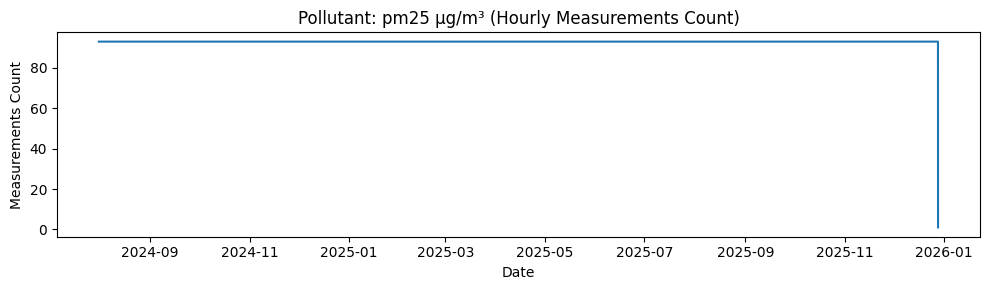

----------------------------------------------------------------
[CO PPM]: 1144927 measurements


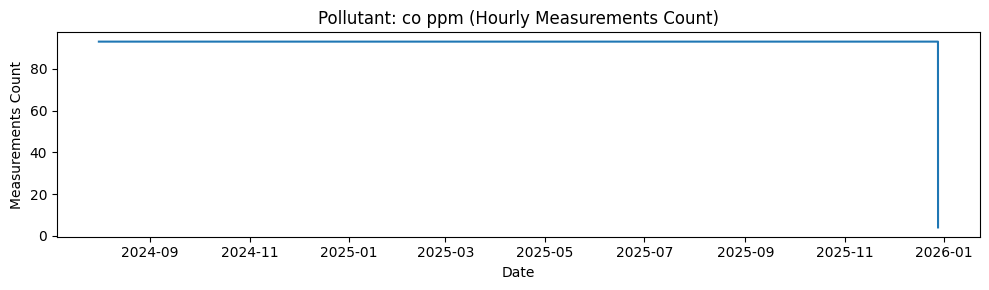

----------------------------------------------------------------
[NO2 PPM]: 1144923 measurements


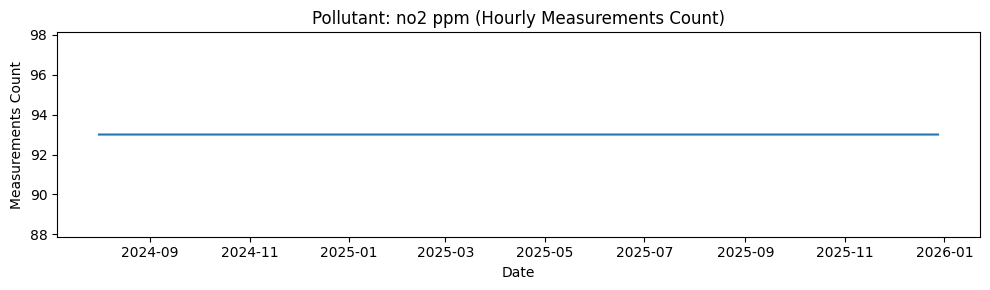

----------------------------------------------------------------
[O3 PPM]: 1144926 measurements


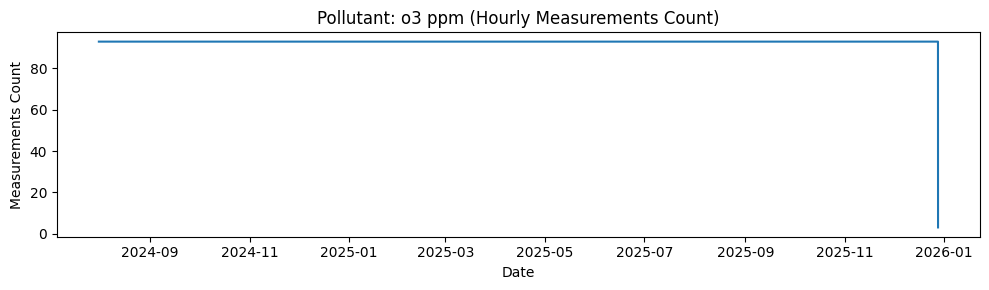

----------------------------------------------------------------
[PM10 ΜG/M³]: 1144923 measurements


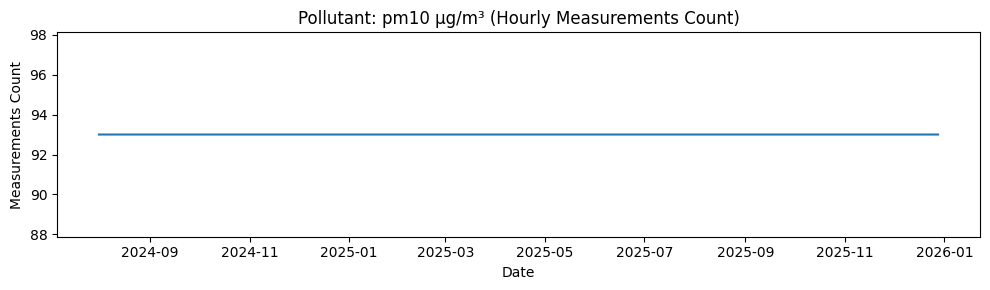

----------------------------------------------------------------
[SO2 PPM]: 1144924 measurements


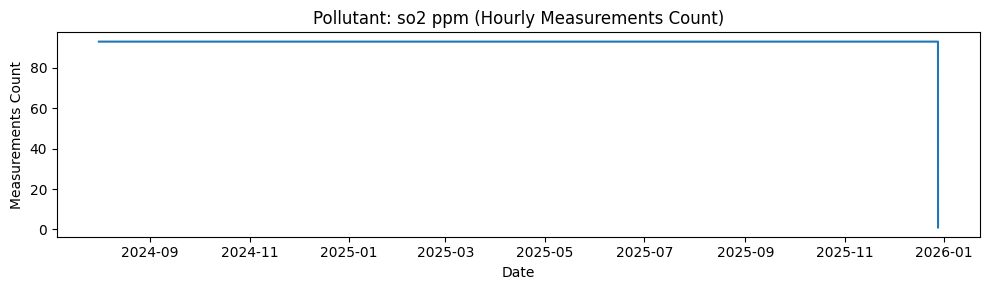

In [29]:
# TEST 2.2: for each pollutant, how many measurements (rows) do we have for the selected locations
# We already selected locations measuring all top pollutants with large coverage

# Just to have an idea of how many hours have low measurement counts
LOW_MEASUREMENT_COUNT_THRESHOLD = 40

title = f"NUMBER OF MEASUREMENTS PER POLLUTANT FOR SELECTED LOCATIONS ({final_df['location_id'].nunique()})"
print(f"{'=' * len(title)}\n{title}\n")

unique_hours = final_df["datetimeto_utc"].nunique()
name_max_length = max(len(str(name)) for name in top_pollutants_name)
for i, pollutant in enumerate(top_pollutants_name):
    df_pollutant = final_df[final_df["sensor_name"] == pollutant]
    df_pollutant_by_datetime = df_pollutant.groupby("datetimeto_utc")["value"].count().reset_index()

    MASK_DATE_FILTER = pd.Series(True, index=df_pollutant_by_datetime.index)  # default: no filter
    # MASK_DATE_FILTER = (df_pollutant_by_datetime["datetimeto_utc"] >= "2025-03-01") & (df_pollutant_by_datetime["datetimeto_utc"] < "2025-05-01")

    print(f"{'-' * len(title)}\n[{pollutant.upper()}]: {df_pollutant.shape[0]} measurements")
    measurements_low_count = df_pollutant_by_datetime[df_pollutant_by_datetime["value"] < LOW_MEASUREMENT_COUNT_THRESHOLD].shape[0]
    # print(f"> Number of hours with low measurement counts (<{LOW_MEASUREMENT_COUNT_THRESHOLD}): {measurements_low_count/unique_hours:.2%} ({measurements_low_count}/{unique_hours})")


    fig, ax =plt.subplots(1, 1, figsize=(10, 3))
    sns.lineplot(data=df_pollutant_by_datetime[MASK_DATE_FILTER], x="datetimeto_utc", y="value", ax=ax)
    ax.set_title(f"Pollutant: {pollutant} (Hourly Measurements Count)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Measurements Count")
    plt.tight_layout()
    plt.show()

# message = f"Locations coverage for all of the top pollutants: {full_locations_count/len(least_common_pollutant_locations):.2%} ({full_locations_count}/{len(least_common_pollutant_locations)} locations)"
# print(f"{message}\n{'_'*len(title)}")


### HEAD

In [119]:
final_df.columns

Index(['location_id', 'sensor_id', 'name', 'value', 'parameter.id', 'parameter.name', 'parameter.units', 'parameter.displayName', 'period.datetimeFrom.local', 'period.datetimeTo.local', 'period.datetimeFrom.utc', 'period.datetimeTo.utc', 'coordinates.latitude', 'coordinates.longitude', 'isMobile', 'isMonitor', 'owner.name', 'provider.name'], dtype='object')

### Extreme values

NUMBER OF EXTREME MEASUREMENTS PER POLLUTANT FOR SELECTED LOCATIONS (93)

------------------------------------------------------------------------
[PM25 ΜG/M³]: 64396 measurements


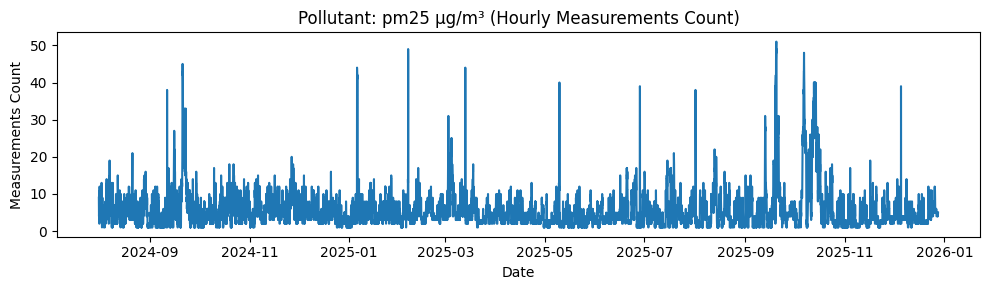

------------------------------------------------------------------------
[CO PPM]: 29512 measurements


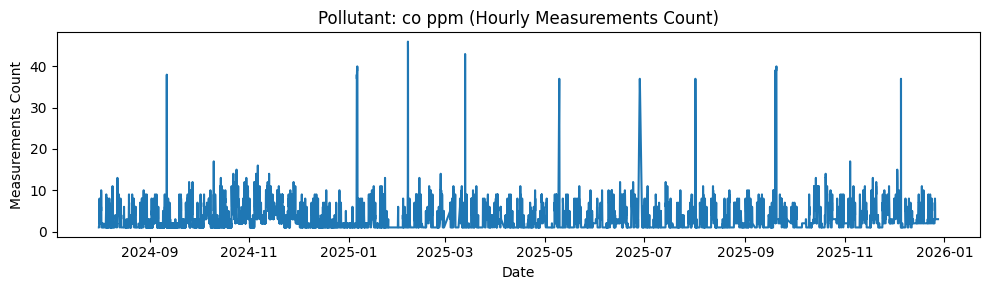

------------------------------------------------------------------------
[NO2 PPM]: 27911 measurements


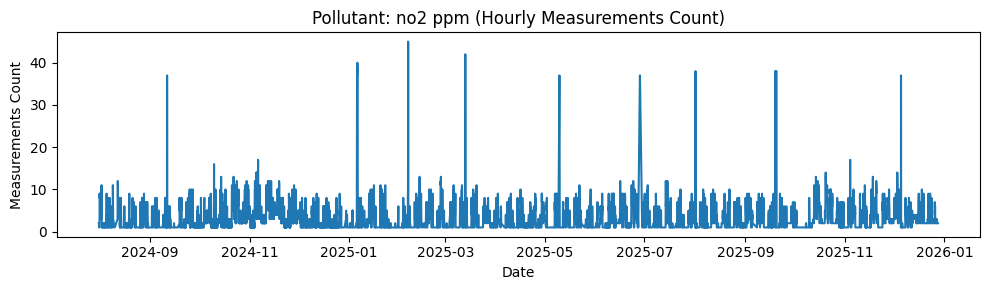

------------------------------------------------------------------------
[O3 PPM]: 31373 measurements


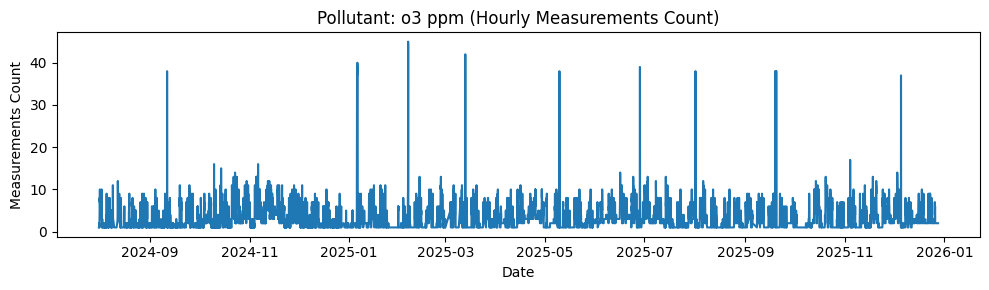

------------------------------------------------------------------------
[PM10 ΜG/M³]: 44702 measurements


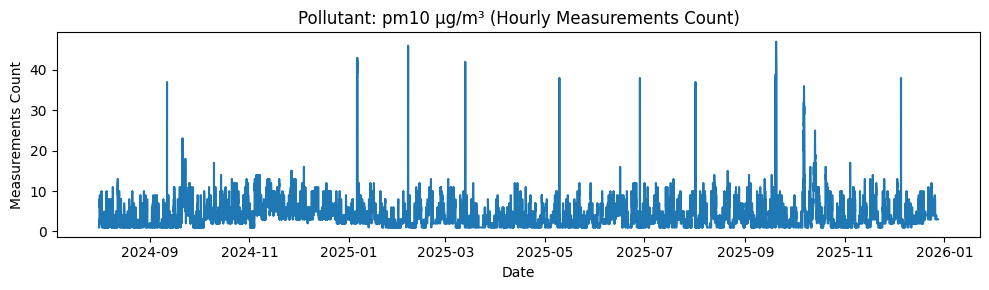

------------------------------------------------------------------------
[SO2 PPM]: 31817 measurements


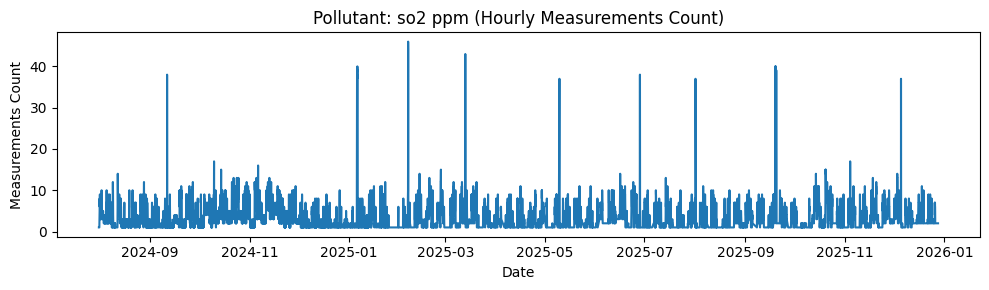

In [30]:
# TEST 3: for each pollutant, how many EXTREME measurements (rows) do we have for the selected locations
# We already selected locations measuring all top pollutants with large coverage

# Just to have an idea of how many hours have low measurement counts
EXTREME_THRESHOLD = 9000

title = f"NUMBER OF EXTREME MEASUREMENTS PER POLLUTANT FOR SELECTED LOCATIONS ({final_df['location_id'].nunique()})"
print(f"{'=' * len(title)}\n{title}\n")

unique_hours = final_df["datetimeto_utc"].nunique()
name_max_length = max(len(str(name)) for name in top_pollutants_name)
for i, pollutant in enumerate(top_pollutants_name):
    df_pollutant = final_df[(final_df["sensor_name"] == pollutant) & (final_df["value"] >= EXTREME_THRESHOLD)]
    df_pollutant_by_datetime = df_pollutant.groupby("datetimeto_utc")["value"].count().reset_index()

    MASK_DATE_FILTER = pd.Series(True, index=df_pollutant_by_datetime.index)  # default: no filter
    # MASK_DATE_FILTER = (df_pollutant_by_datetime["datetimeto_utc"] >= "2025-03-01") & (df_pollutant_by_datetime["datetimeto_utc"] < "2025-05-01")

    print(f"{'-' * len(title)}\n[{pollutant.upper()}]: {df_pollutant.shape[0]} measurements")
    measurements_low_count = df_pollutant_by_datetime[df_pollutant_by_datetime["value"] < LOW_MEASUREMENT_COUNT_THRESHOLD].shape[0]
    # print(f"> Number of hours with low measurement counts (<{LOW_MEASUREMENT_COUNT_THRESHOLD}): {measurements_low_count/unique_hours:.2%} ({measurements_low_count}/{unique_hours})")


    fig, ax =plt.subplots(1, 1, figsize=(10, 3))
    sns.lineplot(data=df_pollutant_by_datetime[MASK_DATE_FILTER], x="datetimeto_utc", y="value", ax=ax)
    ax.set_title(f"Pollutant: {pollutant} (Hourly Measurements Count)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Measurements Count")
    plt.tight_layout()
    plt.show()

# message = f"Locations coverage for all of the top pollutants: {full_locations_count/len(least_common_pollutant_locations):.2%} ({full_locations_count}/{len(least_common_pollutant_locations)} locations)"
# print(f"{message}\n{'_'*len(title)}")


### Final EDA checks

In [56]:
final_df.head(1)

location_id  sensor_id        name  value  parameter.id parameter.name parameter.units parameter.displayName period.datetimeFrom.local   period.datetimeTo.local   period.datetimeFrom.utc     period.datetimeTo.utc  coordinates.latitude  coordinates.longitude  isMobile  isMonitor                         owner.name                      provider.name
0      2623440    8542022  pm10 µg/m³   23.0             1           pm10           µg/m³                  PM10 2024-07-01 09:00:00+09:00 2024-07-01 10:00:00+09:00 2024-07-01 00:00:00+00:00 2024-07-01 01:00:00+00:00             37.593749             126.949534     False       True  Unknown Governmental Organization  Korea Air Ministry of Environment

In [ ]:
print(f"{'='*72}\nFINAL DATAFRAME: ALL LOCATIONS ({len(KEPT_LOCATIONS)}/{len(selected_locations)}) WITH +{THRESHOLD:.2%} COVERAGE FOR ALL POLLUTANTS")
print(f"Shape: {final_df.shape}")
print(f"First: {final_df["datetimeto_utc"].min()} (UTC)")
print(f"Last : {final_df["datetimeto_utc"].max()} (UTC)")
print()

final_unique_locations = final_df["location_id"].unique()
print(f"{'-'*72}\nLOCATIONS: {len(final_unique_locations)}\n{final_unique_locations}")
print("\n")


print(f"\n{'-'*72}\nPOLLUTANTS:")
print(final_df["name"].value_counts().reset_index())
print("\n")

print(f"\n{'-'*72}\nVALUES (describe):")
display(final_df.groupby("name")["value"].describe())
print("\n")

print(f"OWNERS (value_counts):")
print(final_df["owner.name"].value_counts())
print(f"\nPROVIDERS (value_counts):")
print(final_df["provider.name"].value_counts())
print("\n")

print(f"isMobile (value_counts):")
print(final_df["isMobile"].value_counts())
print(f"\nisMonitor (value_counts):")
print(final_df["isMonitor"].value_counts())
print("\n")


FINAL DATAFRAME: ALL LOCATIONS (58/73) WITH +90.00% COVERAGE FOR ALL POLLUTANTS
Shape: (4918548, 18)
First: 2024-05-01 00:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)

------------------------------------------------------------------------
LOCATIONS: 58
[2623440 2622675 2622950 2622916 2623214 2623052 2622627 2622608 2623586
 2623504 2622932 2623346 2623422 2622714 2623394 2622851 2622782 2622858
 2623344 2622689 2623321 2623557 2623811 2623080 2623112 2623681 2623198
 2622918 2623154 2622727 2622796 2622827 2623643 2623424 2623444 2623048
 2623069 2623563 2622995 2623004 2623465 2623259 2623718 2623345 2622724
 2622907 2623532 2622837 2623538 2622586 2622825 2623430 2623116 2623078
 2623442 2623194 2622807 2623679]



------------------------------------------------------------------------
POLLUTANTS:
         name   count
0  pm10 µg/m³  819758
1      co ppm  819758
2      o3 ppm  819758
3  pm25 µg/m³  819758
4     so2 ppm  819758
5     no2 ppm  819758



----------------

count        mean          std  min      25%      50%      75%      max
name                                                                                  
co ppm      819758.0  205.300103  1416.641751  0.0   0.3000   0.3800   0.5000  10000.0
no2 ppm     819758.0  204.566148  1415.498799  0.0   0.0093   0.0153   0.0255  10000.0
o3 ppm      819758.0  240.869807  1533.094355  0.0   0.0166   0.0292   0.0433  10000.0
pm10 µg/m³  819758.0  391.720335  1862.409862  0.0  18.0000  27.0000  41.0000  10000.0
pm25 µg/m³  819758.0  505.134495  2153.755010  0.0   8.0000  14.0000  24.0000  10000.0
so2 ppm     819758.0  239.487839  1528.888989  0.0   0.0021   0.0025   0.0030  10000.0



OWNERS (value_counts):
owner.name
Unknown Governmental Organization    4918548
Name: count, dtype: int64

PROVIDERS (value_counts):
provider.name
Korea Air Ministry of Environment    4918548
Name: count, dtype: int64


isMobile (value_counts):
isMobile
False    4918548
Name: count, dtype: int64

isMonitor (value_counts):
isMonitor
True    4918548
Name: count, dtype: int64




### DEEP DIVE POLLUTION SPIKE: pm25 µg/m³

In [222]:
EXTREME_THRESHOLD = 5000

In [ ]:
FINAL_POLLUTANTS = ["pm25 µg/m³"]
# FINAL_POLLUTANTS = top_pollutants_name

# Date filter (mask)
PM25_PEAKS = [
    # Peak 1 hour (PM25: 16 x 10k)
    (pd.Timestamp("2025-11-16T21:30:00").tz_localize(timezone), pd.Timestamp("2025-11-16T22:30:00").tz_localize(timezone)),

    # Peak over 5 hours gradually (PM25: 8 > 41 > 40 > 41 > 7 off)
    (pd.Timestamp("2025-02-06T13:30:00").tz_localize(timezone), pd.Timestamp("2025-02-06T14:30:00").tz_localize(timezone)),
    (pd.Timestamp("2025-02-06T14:30:00").tz_localize(timezone), pd.Timestamp("2025-02-06T15:30:00").tz_localize(timezone)),
    (pd.Timestamp("2025-02-06T15:30:00").tz_localize(timezone), pd.Timestamp("2025-02-06T16:30:00").tz_localize(timezone)),
]

peaks_locations = []
for peak in PM25_PEAKS:
    peak_mask = (final_df["datetimeto_utc"] >= peak[0]) & (final_df["datetimeto_utc"] <= peak[1])
    df_pollutant = final_df[(final_df["value"] > 2000) & (final_df["name"] == FINAL_POLLUTANTS[0]) & peak_mask][["location_id", "name", "value", "datetimeto_utc"]]
    print(f"Shape: {df_pollutant.shape} | Unique locations: {df_pollutant["location_id"].nunique()}")
    # display(df_pollutant.head(100))

    peaks_locations.append(df_pollutant["location_id"].unique())

Shape: (16, 4) | Unique locations: 16
Shape: (41, 4) | Unique locations: 41
Shape: (40, 4) | Unique locations: 40
Shape: (41, 4) | Unique locations: 41


Extreme measurements (>5000) : (8, 4)
Unique locations             :  8
[2623069, 2623112, 2622851, 2623345, 2622827, 2622858, 2623586, 2623048]

Extreme measurements (>5000) : (41, 4)
Unique locations             :  41
[2623532, 2622689, 2623586, 2622586, 2622782, 2623557, 2623069, 2622916, 2622796, 2622727, 2623504, 2623344, 2623811, 2623154, 2622950, 2623052, 2623465, 2623679, 2623004, 2623440, 2623194, 2622858, 2623346, 2623394, 2623345, 2622827, 2623112, 2623116, 2623718, 2623198, 2623259, 2622608, 2623080, 2623424, 2622837, 2623563, 2622675, 2623430, 2623048, 2623321, 2622907]

Extreme measurements (>5000) : (40, 4)
Unique locations             :  40
[2623345, 2623004, 2622858, 2623346, 2623586, 2623069, 2622782, 2623112, 2622675, 2623048, 2623198, 2623465, 2622950, 2623194, 2622796, 2623394, 2623116, 2622827, 2623718, 2622608, 2623424, 2623080, 2623563, 2623321, 2623430, 2622907, 2622837, 2623259, 2623532, 2623811, 2622689, 2623679, 2623052, 2623154, 2622727, 2623440, 2623344, 2

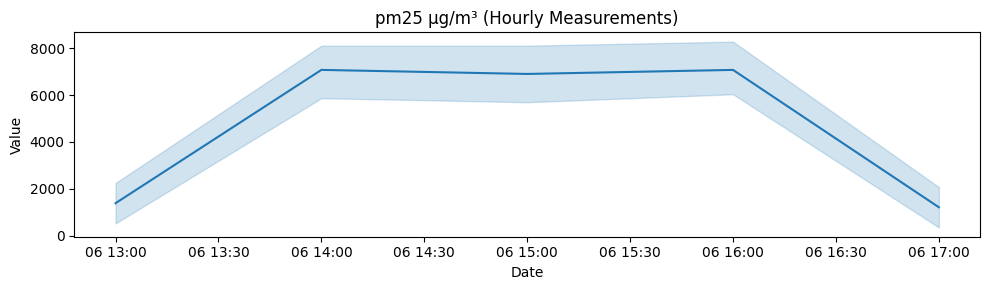

In [ ]:
import matplotlib.dates as mdates

FINAL_DATE_FILTER = True
FINAL_POLLUTANTS = ["pm25 µg/m³"]
# FINAL_POLLUTANTS = top_pollutants_name

# Date filter (mask)

# Peak 1 hour (PM25: 16 x 10k)
# final_start_date = pd.Timestamp("2025-11-16T20:30:00").tz_localize(timezone)
# final_end_date = pd.Timestamp("2025-11-16T23:30:00").tz_localize(timezone)

# Peak over 3 hours (PM25: 36 x 10k): [2623465, 2622916, 2623563, 2622782, 2623346, 2623430, 2623344, 2623532, 2622586, 2623679, 2623718, 2623259, 2623424, 2622950, 2623004, 2623321, 2623557, 2622727, 2623440, 2622689, 2623198, 2623052, 2623154, 2623116, 2622907, 2623811, 2622837, 2623194, 2623586, 2623394, 2622675, 2623048, 2622796, 2622608, 2623112, 2623080]
# final_start_date = pd.Timestamp("2025-06-28T14:30:00").tz_localize(timezone)
# final_end_date = pd.Timestamp("2025-06-28T19:30:00").tz_localize(timezone)

# Peak over 5 hours gradually (PM25: 8 > 41 > 40 > 41 > 7 off)
final_start_date = pd.Timestamp("2025-02-06T12:30:00").tz_localize(timezone)
final_end_date = pd.Timestamp("2025-02-06T17:30:00").tz_localize(timezone)

if FINAL_DATE_FILTER:
    date_filter = (final_df["datetimeto_utc"] >= final_start_date) & (final_df["datetimeto_utc"] <= final_end_date)
else:
    date_filter = pd.Series(True, index=final_df["datetimeto_utc"].index)  # default: no filter

# Make a groupby to make a time series: just change the aggregation method: mean, median, count...
final_value_groupby_name = final_df[date_filter].groupby(['datetimeto_utc', 'name'])['value'].mean().reset_index()

for pollutant in FINAL_POLLUTANTS:
    # GROUPBY (MEAN)
    # df_pollutant = final_value_groupby_name[final_value_groupby_name["name"] == pollutant]

    # Used to plot, we need both the normal and extreme values
    df_pollutant = final_df[(final_df["name"] == pollutant) & date_filter][["location_id", "name", "value", "datetimeto_utc"]]

    # Used to make stats about extreme values
    df_extreme_values = df_pollutant[df_pollutant["value"] > EXTREME_THRESHOLD].sort_values(by="datetimeto_utc")

    for hour in df_extreme_values["datetimeto_utc"].unique():
        df_hour = df_extreme_values[df_extreme_values["datetimeto_utc"] == hour]

        hour_unique_locations = df_hour["location_id"].unique()
        print(f"Extreme measurements (>{EXTREME_THRESHOLD}) : {df_hour.shape}")
        print(f"Unique locations             :  {len(hour_unique_locations)}\n{hour_unique_locations.tolist()}\n")

    # display(df_pollutant.head(100))


    fig, ax = plt.subplots(figsize=(10, 3))
    sns.lineplot(data=df_pollutant, x="period.datetimeTo.local", y="value", ax=ax)

    # ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    # ax.grid(visible=True, which='major', axis='x', linestyle='--', alpha=0.5, zorder=1)

    ax.set_title(f"{pollutant} (Hourly Measurements)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [242]:
a = [2623069, 2623112, 2622851, 2623345, 2622827, 2622858, 2623586, 2623048]
b = [2623532, 2622689, 2623586, 2622586, 2622782, 2623557, 2623069, 2622916, 2622796, 2622727, 2623504, 2623344, 2623811, 2623154, 2622950, 2623052, 2623465, 2623679, 2623004, 2623440, 2623194, 2622858, 2623346, 2623394, 2623345, 2622827, 2623112, 2623116, 2623718, 2623198, 2623259, 2622608, 2623080, 2623424, 2622837, 2623563, 2622675, 2623430, 2623048, 2623321, 2622907]
c = [2623345, 2623004, 2622858, 2623346, 2623586, 2623069, 2622782, 2623112, 2622675, 2623048, 2623198, 2623465, 2622950, 2623194, 2622796, 2623394, 2623116, 2622827, 2623718, 2622608, 2623424, 2623080, 2623563, 2623321, 2623430, 2622907, 2622837, 2623259, 2623532, 2623811, 2622689, 2623679, 2623052, 2623154, 2622727, 2623440, 2623344, 2623557, 2622916, 2622586]
d = [2623321, 2622950, 2622608, 2622858, 2622782, 2622916, 2623116, 2623194, 2623811, 2623112, 2623532, 2623465, 2623345, 2622796, 2623394, 2622827, 2623718, 2623424, 2623080, 2623563, 2623430, 2622907, 2623259, 2622727, 2622689, 2622586, 2623557, 2623440, 2623344, 2623052, 2623679, 2623198, 2622837, 2623004, 2622714, 2623069, 2623048, 2623154, 2623586, 2622675, 2623346]
e = [2623345, 2623069, 2622825, 2622858, 2623679, 2622827, 2622714]

first = e
second = d
intersection = [n for n in first if n in second]
print(f"% of [a] in [b]: {len(intersection)/len(first):.2%}")


% of [a] in [b]: 85.71%


In [220]:
a = [2623465, 2622916, 2623563, 2622782, 2623346, 2623430, 2623344, 2623532, 2622586, 2623679, 2623718, 2623259, 2623424, 2622950, 2623004, 2623321, 2623557, 2622727, 2623440, 2622689, 2623198, 2623052, 2623154, 2623116, 2622907, 2623811, 2622837, 2623194, 2623586, 2623394, 2622675, 2623048, 2622796, 2622608, 2623112, 2623080]

b = [2623465, 2622916, 2623563, 2622782, 2623346, 2623430, 2623344, 2623532, 2622586, 2623679, 2623718, 2623259, 2623424, 2622950, 2623004, 2623321, 2623557, 2622727, 2623440, 2622689, 2623198, 2623052, 2623154, 2623116, 2622907, 2623811, 2622837, 2623194, 2623586, 2623394, 2622675, 2623048, 2622796, 2622608, 2623112, 2623080]

c = [2623465, 2622916, 2623563, 2622782, 2623346, 2623430, 2623344, 2623532, 2622586, 2623679, 2623718, 2623259, 2623424, 2622950, 2623004, 2623321, 2623557, 2622727, 2623440, 2622689, 2623198, 2623052, 2623154, 2623116, 2622907, 2623811, 2622837, 2623194, 2623586, 2623394, 2622675, 2623048, 2622796, 2622608, 2623112, 2623080]


print(sorted(a) == sorted(b))
print(sorted(a) == sorted(c))
print(sorted(b) == sorted(c))


True
True
True


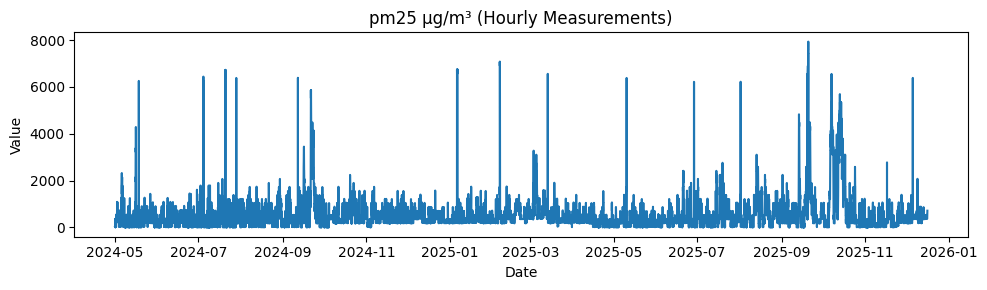

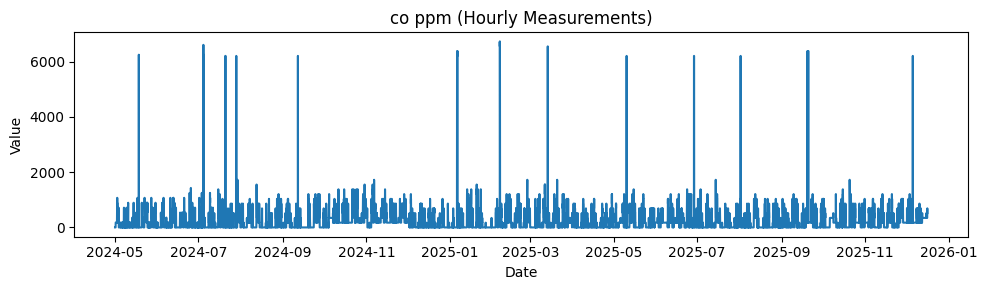

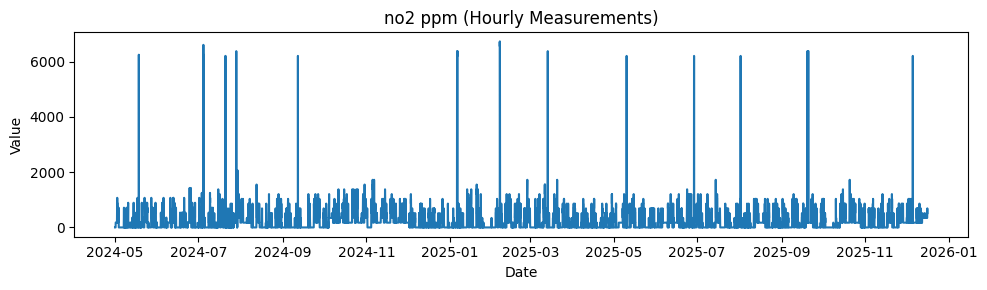

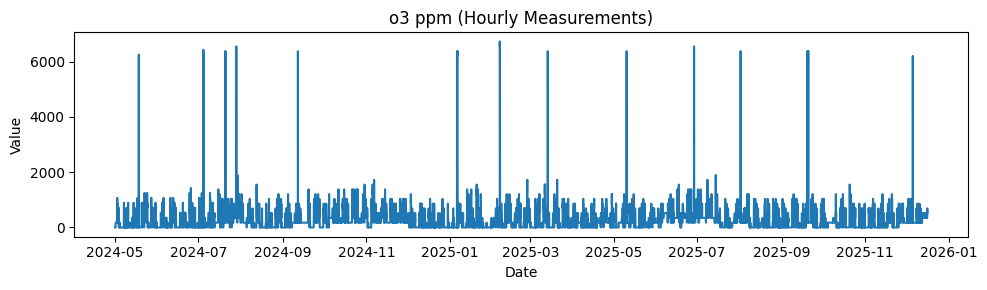

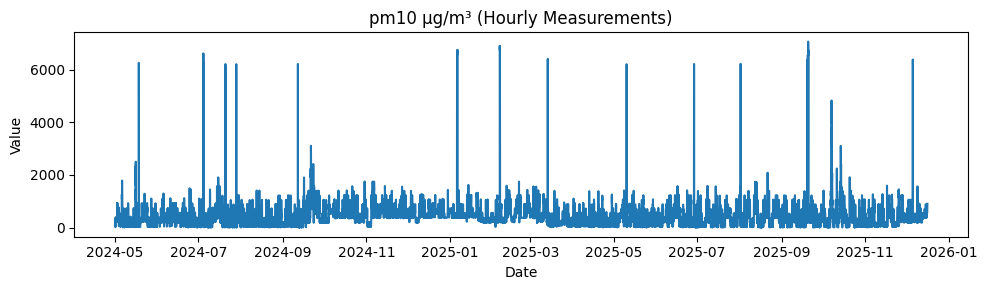

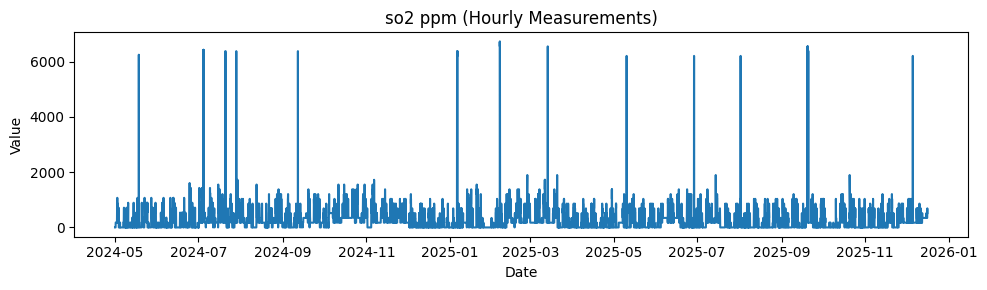

In [ ]:
import matplotlib.dates as mdates

FINAL_SHOW_HOURS = False
FINAL_DATE_FILTER = False
# FINAL_POLLUTANTS = ["pm25 µg/m³"]
FINAL_POLLUTANTS = top_pollutants_name

# myFmt = mdates.DateFormatter("%d/%m %H:%M")
# myFmt = mdates.DateFormatter("%d/%m %Hh")

# Date filter (mask)
final_start_date = pd.Timestamp("2025-05-05T12:00:00").tz_localize(timezone)
final_end_date = pd.Timestamp("2025-05-16T00:00:00").tz_localize(timezone)

if FINAL_DATE_FILTER:
    date_filter = (final_df["datetimeto_utc"] >= final_start_date) & (final_df["datetimeto_utc"] <= final_end_date)
else:
    date_filter = pd.Series(True, index=final_df["datetimeto_utc"].index)  # default: no filter

# Make a groupby to make a time series: just change the aggregation method: mean, median, count...
final_value_groupby_name = final_df[date_filter].groupby(['datetimeto_utc', 'name'])['value'].mean().reset_index()

for pollutant in FINAL_POLLUTANTS:
    df_pollutant = final_value_groupby_name[final_value_groupby_name["name"] == pollutant]

    fig, ax = plt.subplots(figsize=(10, 3))
    sns.lineplot(data=df_pollutant, x="datetimeto_utc", y="value", ax=ax)
    ax.set_title(f"{pollutant} (Hourly Measurements)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Value")

    if FINAL_SHOW_HOURS:
        # ax.xaxis.set_major_locator(mdates.HourLocator())
        # ax.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m-%H:%M"))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [53]:
# Anomaly: 2025-12-05T19:00:00+09:00
final_df[final_df["period.datetimeTo.local"] == '2025-12-05T19:00:00+09:00']["value"].describe()

count      348.000000
mean      6266.380669
std       4841.854927
min          0.000900
25%          0.860000
50%      10000.000000
75%      10000.000000
max      10000.000000
Name: value, dtype: float64

In [67]:
# Filter to only show extreme values

EXTREME_VALUE = 5000
FINAL_DATE_FILTER = True
# FINAL_POLLUTANTS = ["pm25 µg/m³"]
FINAL_POLLUTANTS = top_pollutants_name

# Date filter (mask)
final_start_date = pd.Timestamp("2024-01-01T12:00:00").tz_localize(timezone)
final_end_date = pd.Timestamp("2025-12-31").tz_localize(timezone)

if FINAL_DATE_FILTER:
    date_filter = (final_df["period.datetimeTo.local"] >= final_start_date) & (final_df["period.datetimeTo.local"] <= final_end_date)
else:
    date_filter = pd.Series(True, index=final_df["period.datetimeTo.local"].index)  # default: no filter

final_df_extreme_values = final_df[date_filter & (final_df["value"] > EXTREME_VALUE)]


display(final_df_extreme_values.head())

print(f"Number of extreme values (>{EXTREME_VALUE}): {len(final_df_extreme_values)}")
print(f"Number of locations with extreme values (>{EXTREME_VALUE}): {final_df_extreme_values["location_id"].nunique()}")

# print(f"Number of extreme values (>{EXTREME_VALUE}): {len(final_df_extreme_values)}")

location_id  sensor_id        name    value  parameter.id parameter.name parameter.units parameter.displayName period.datetimeFrom.local   period.datetimeTo.local   period.datetimeFrom.utc     period.datetimeTo.utc  coordinates.latitude  coordinates.longitude  isMobile  isMonitor                         owner.name                      provider.name
76       2623440    8542022  pm10 µg/m³  10000.0             1           pm10           µg/m³                  PM10 2024-07-04 15:00:00+09:00 2024-07-04 16:00:00+09:00 2024-07-04 06:00:00+00:00 2024-07-04 07:00:00+00:00             37.593749             126.949534     False       True  Unknown Governmental Organization  Korea Air Ministry of Environment
78       2623440    8542022  pm10 µg/m³  10000.0             1           pm10           µg/m³                  PM10 2024-07-04 17:00:00+09:00 2024-07-04 18:00:00+09:00 2024-07-04 08:00:00+00:00 2024-07-04 09:00:00+00:00             37.593749             126.949534     False       True  Unknown Governmental Organization  Korea Air Ministry of Environment
79       2623440    8542022  pm10 µg/m³  10000.0             1           pm10           µg/m³                  PM10 2024-07-04 18:00:00+09:00 2024-07-04 19:00:00+09:00 2024-07-04 09:00:00+00:00 2024-07-04 10:00:00+00:00             37.593749             126.949534     False       True  Unknown Governmental Organization  Korea Air Ministry of Environment
80       2623440    8542022  pm10 µg/m³  10000.0             1           pm10           µg/m³                  PM10 2024-07-04 19:00:00+09:00 2024-07-04 20:00:00+09:00 2024-07-04 10:00:00+00:00 2024-07-04 11:00:00+00:00             37.593749             126.949534     False       True  Unknown Governmental Organization  Korea Air Ministry of Environment
211      2623440    8542022  pm10 µg/m³  10000.0             1           pm10           µg/m³                  PM10 2024-07-10 11:00:00+09:00 2024-07-10 12:00:00+09:00 2024-07-10 02:00:00+00:00 2024-07-10 03:00:00+00:00             37.593749             126.949534     False       True  Unknown Governmental Organization  Korea Air Ministry of Environment

Number of extreme values (>5000): 142735
Number of locations with extreme values (>5000): 58


In [72]:
final_df = selected_df[selected_df["location_id"].isin(KEPT_LOCATIONS)]

print(f"FINAL DATAFRAME: ALL LOCATIONS ({len(KEPT_LOCATIONS)}/{len(selected_locations)}) WITH +{THRESHOLD:.2%} COVERAGE FOR ALL POLLUTANTS")
print(f"Shape: {final_df.shape}")
print(f"First: {final_df["period.datetimeTo.local"].min()} (UTC)")
print(f"Last : {final_df["period.datetimeTo.local"].max()} (UTC)")

FINAL DATAFRAME: ALL LOCATIONS (58/73) WITH +90.00% COVERAGE FOR ALL POLLUTANTS
Shape: (4918548, 18)
First: 2024-05-01 00:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)


In [76]:
extreme_df = final_df[final_df["value"] > 3000]

print(f"EXTREME DATAFRAME: VALUE > {EXTREME_VALUE}")
print(f"Shape: {extreme_df.shape}")
print(f"First: {extreme_df["period.datetimeTo.local"].min()} (UTC)")
print(f"Last : {extreme_df["period.datetimeTo.local"].max()} (UTC)")

EXTREME DATAFRAME: VALUE > 5000
Shape: (142735, 18)
First: 2024-05-01 02:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)


In [123]:
for pollutant in top_pollutants_name:
    df_pollutant = extreme_df[extreme_df["name"] == pollutant]

    print(f"{pollutant.upper()}: VALUE > {EXTREME_VALUE}")
    print(f"Shape: {df_pollutant.shape}")
    print(f"First: {df_pollutant["period.datetimeTo.local"].min()} (UTC)")
    print(f"Last : {df_pollutant["period.datetimeTo.local"].max()} (UTC)")
    print(f"Min value: {df_pollutant["value"].min()}")
    print(f"Max value: {df_pollutant["value"].max()}")
    display(df_pollutant["location_id"].nunique())
    print()


# & ("period.datetimeTo.local" == extreme_df[extreme_df["name"] == pollutant]["period.datetimeTo.local"].max())

display()



PM25 ΜG/M³: VALUE > 5000
Shape: (40114, 18)
First: 2024-05-01 02:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58


CO PPM: VALUE > 5000
Shape: (16797, 18)
First: 2024-05-01 11:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58


NO2 PPM: VALUE > 5000
Shape: (16768, 18)
First: 2024-05-01 11:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58


O3 PPM: VALUE > 5000
Shape: (19743, 18)
First: 2024-05-01 11:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58


PM10 ΜG/M³: VALUE > 5000
Shape: (29681, 18)
First: 2024-05-01 02:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58


SO2 PPM: VALUE > 5000
Shape: (19632, 18)
First: 2024-05-01 11:00:00+09:00 (UTC)
Last : 2025-12-16 11:00:00+09:00 (UTC)
Min value: 10000.0
Max value: 10000.0


58

In [93]:
max_df = final_df[final_df["value"] == 10000]
max_df.shape

(142735, 18)

In [95]:
max_df["location_id"].nunique()

58

In [68]:
# final_df_extreme_values.set_index("period.datetimeTo.local").sort_index()

extreme_timeserie = final_df[final_df["value"] > EXTREME_VALUE]["period.datetimeTo.local"].value_counts().sort_index()
extreme_timeserie[:10]
# extreme_timeserie = final_df_extreme_values["period.datetimeTo.local"].value_counts().sort_index()

# final_df_extreme_values["value"].describe()

# extreme_groupby_pollutant = final_df_extreme_values.groupby(["period.datetimeTo.local", "name"])["value"].count()
# display(extreme_groupby_pollutant.describe())

# for pollutant in FINAL_POLLUTANTS:
#     df_pollutant = final_df_extreme_values[final_df_extreme_values["name"] == pollutant]

#     fig, ax = plt.subplots(figsize=(10, 3))
#     sns.scatterplot(data=df_pollutant, x="period.datetimeTo.local", y="value")
#     plt.tight_layout()
#     plt.show()
#     plt.close(fig)

period.datetimeTo.local
2024-05-01 02:00:00+09:00    2
2024-05-01 03:00:00+09:00    3
2024-05-01 05:00:00+09:00    2
2024-05-01 07:00:00+09:00    1
2024-05-01 10:00:00+09:00    1
2024-05-01 11:00:00+09:00    7
2024-05-01 12:00:00+09:00    8
2024-05-01 13:00:00+09:00    7
2024-05-01 14:00:00+09:00    7
2024-05-01 15:00:00+09:00    8
Name: count, dtype: int64

#### Archives

In [ ]:
# OVERLAP of each pollutant with each others

# TODO: Test ONLY the unique locations of the least common pollutant
# but test

# Either jsut this one:
# least_common_pollutant_locations = filtered_df[filtered_df["name"] == least_common_pollutant]["location_id"].unique()
# # or the tested_pollutant_locations
# print(len(least_common_pollutant_locations))

name_max_length = max(len(name) for name in top_pollutants_name)
for pollutant in top_pollutants_name:
    tested_pollutant = pollutant
    tested_pollutant_locations = filtered_df[filtered_df["name"] == tested_pollutant]["location_id"].unique()
    other_pollutants = [p for p in top_pollutants_name if p != tested_pollutant]


    # print(f"Tested pollutant: {tested_pollutant}")
    print(f"[TESTING: {tested_pollutant.upper()} LOCATIONS ({len(tested_pollutant_locations)}) : Testing overlap of each pollutant with the tested pollutant:")
    print(f"  Other pollutants: {other_pollutants}")
    for other in other_pollutants:
        pollutant_locations = filtered_df[filtered_df["name"] == other]["location_id"].unique()

        common_locations = set(tested_pollutant_locations).intersection(set(pollutant_locations))
        print(f"  {other:<{name_max_length}} : {len(common_locations)/len(tested_pollutant_locations):>7.2%} ({len(common_locations)}/{len(tested_pollutant_locations)})")
    print()

In [ ]:
# Test if one of the locations measuring um003 actually measures all metrics

location_to_test = unique_locations_tested[4]
df_location = filtered_df[filtered_df["location_id"] == location_to_test]
measured_parameters = df_location["name"].unique().tolist()
print(f"Location ID {location_to_test} measures the following parameters: {measured_parameters}")

In [ ]:
pollutants_dict = {}

# Get the unique locations list for each pollutant
for pollutant in top_pollutants_name:
    unique_locations = filtered_df[filtered_df["name"] == pollutant]["location_id"].unique()
    pollutants_dict[pollutant] = unique_locations
    # pollutants_dict[pollutant] = len(unique_locations)
    # print(f"{pollutant}: {len(unique_locations)} unique locations")

# print()
# print(pollutants_dict)

# Compare each pollutant's unique locations with pm25 unique locations to find overlaps
for pollutant in top_pollutants_name:
    if pollutant == "pm25 µg/m³":
        continue  # Skip comparison with itself
    unique_locations = pollutants_dict[pollutant]
    overlap = set(unique_locations_pm25).intersection(set(unique_locations))
    print(f"Overlap between pm25 µg/m³ and {pollutant}: {len(overlap)/len(unique_locations):.2%} ({len(overlap)}/{len(unique_locations)} locations)")

In [ ]:
result_df = (
    filtered_df.groupby("name")
    .agg(station_count=('sensor_id', 'count')) # Use a tuple (new_col_name, aggregation_func)
    .sort_values(by='station_count', ascending=False)
)
display(result_df)

In [ ]:
filtered_df["name"].value_counts()

In [ ]:
groupby = filtered_df.groupby(["location_id", "name"]).size().sort_values(ascending=False)
pprint(groupby)

<br>

---
### ***↪***&nbsp;&nbsp;**Maps**

TODO:
- MAPS: Add a number grid over all municipalities to identify them from an attached legend
- CHLOROPLETH MAP: add a municipality column for each location

#### Map functions (customization)

In [32]:
# ================================================================
# CUSTOMIZE COLORAXIES (COLOR SCHEMES) AND COLORBAR (LEGEND)

def customize_colorbar(option: str = "vertical", **kwargs) -> dict:
    if option == "vertical":
        x = kwargs.get("x", 0.90)
        y = kwargs.get("y", 0.80)
        len = kwargs.get("len", 0.3)
        thickness = kwargs.get("thickness", 15)

        return dict(
            # tickmode="array",
            # tickvals=[0, 10, 20, 30, 40, 50, 100],
            # ticktext=["0", "10", "20", "30", "40", "50", "100+"],
            x=x,
            y=y,
            len=len,
            thickness=thickness,
            bgcolor="rgba(255,255,255, 1)",
            bordercolor="white",
            borderwidth=1,
            title=dict(text=""),
            # tickfont=dict(size=12)
        )
    else:
        x = kwargs.get("x", 0.87)
        y = kwargs.get("y", 0.06)
        len = kwargs.get("len", 0.23)
        thickness = kwargs.get("thickness", 10)

        return dict(
            orientation="h",
            x=x,
            y=y,
            len=len,
            thickness=thickness,
            bgcolor="rgba(255,255,255, 1)",
            bordercolor="white",
            title=dict(text=""),
            # tickfont=dict(size=12)
        )

    return fig

def customize_coloraxes(point_coloraxis: list, border_coloraxis: list, **kwargs) -> dict:
    cmin = kwargs.get("cmin", 0)
    cmax = kwargs.get("cmax", None)

    return {
        # Point coloraxis
        "coloraxis": dict(
            colorscale=point_coloraxis,
            cmin=cmin,
            cmax=cmax,
            # colorbar=customize_colorbar(option="vertical")
        ),
        # Border coloraxis
        "coloraxis2": dict(
            colorscale=border_coloraxis,
            cmin=cmin,
            cmax=cmax,
            showscale=False
        )
    }


# ================================================================
# CUSTOMIZE MAP LAYERS (GEOJSON)

def customize_map_layers(city_geojson: dict, seoul_geojson_districts: dict | None = None, option: str = "default", **kwargs) -> list:
    color = kwargs.get("color", "")
    dimmer_color = kwargs.get("dimmer_color", "rgba(0, 0, 0, 0.2)")
    glowing_border = kwargs.get("glowing_border", False)

    border_color = kwargs.get("border_color", "white")
    border_width = kwargs.get("border_width", 2)

    sub_border_color = kwargs.get("sub_border_color", "rgba(0,0,0,0.4)")
    sub_border_width = kwargs.get("sub_border_width", 2)
    sub_dashes = kwargs.get("sub_dashes", [2, 2])

    map_layers = []

    # Create the Mask geojson
    world_coords = [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]
    city_coords = city_geojson['features'][0]['geometry']['coordinates']
    mask_geojson = {
        "type": "FeatureCollection",
        "features": [{
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [world_coords] + city_coords if isinstance(city_coords[0][0], list) else [world_coords, city_coords[0]]
            },
            "properties": {}
        }]
    }

    if option == "default":
        map_layers = [
            # LAYER 1: The "Dimmer" (Everything EXCEPT Seoul)
            {
                "sourcetype": "geojson",
                "source": mask_geojson,
                "type": "fill",
                "color": f"{dimmer_color}", # Darken the rest of the world
                "below": "traces",
            },
            # LAYER 3: The Thick White Border for Seoul
            # {
            #     "sourcetype": "geojson",
            #     "source": city_geojson,
            #     "type": "line",
            #     "color": "rgba(255, 255, 255, 1)",
            #     "line": {"width": 2},
            #     "below": "traces"
            # },
            # # LAYER 4: Dim Seoul (less)
            # {
            #     "sourcetype": "geojson",
            #     "source": seoul_geojson,
            #     "type": "fill",
            #     "color": "rgba(0, 0, 0, 0.1)", # Darken Seoul
            #     "below": "traces"
            # },
        ]

        # LAYER: The Seoul Municipalities
        if seoul_geojson_districts is not None:
            map_layers.append({
                "sourcetype": "geojson",
                "source": seoul_geojson_districts,
                "type": "line",
                "color": f"{sub_border_color}",
                "line": {
                    "width": sub_border_width,
                    "dash": sub_dashes,  # [dash length, gap length]
                },
                "below": "traces",
            })

        # BORDER: Seoul Borders
        if glowing_border:
            glow_layers = []
            for width, opacity in zip([2, 5, 10, 15], [0.8, 0.4, 0.2, 0.1]):
                glow_layers.append({
                    "sourcetype": "geojson",
                    "source": city_geojson,
                    "type": "line",
                    "color": f"rgba(255, 255, 255, {opacity})",
                    "line": {"width": width},
                    "below": "traces"
                })
            map_layers.extend(glow_layers)
        else:
            map_layers.extend([{
                "sourcetype": "geojson",
                "source": city_geojson,
                "type": "line",
                "color": border_color,
                "line": {"width": border_width},
                "below": "traces"
            }])

    return map_layers


# ================================================================
# CUSTOMIZE POINTS

# TODO: Add an exponential "size" feature for both the size of the points and the colors
def customize_points(fig: PlotlyFigure, df: pd.DataFrame, lat: str, lon: str, **kwargs) -> PlotlyFigure:
    color = kwargs.get("color", None)
    size_column = kwargs.get("size", None)
    size_max = kwargs.get("size_max", 24)
    border = kwargs.get("border", size_column is None)

    hover_name = kwargs.get("hover_name", None)
    hover_data = kwargs.get("hover_data", None)

    exponential = kwargs.get("exponential", False)

    # Reset all traces
    fig.data = []

    border_scaling_ratio = 1.5
    base_point_size = 16

    point_size = base_point_size if size_column is None else 0
    border_size = int(point_size*border_scaling_ratio) if size_column is None else None

    df_plot = df

    # EXPONENTIAL MODE
    if exponential and size_column:
        # Example: Square the values to create exponential visual scaling
        df_plot[size_column + "_exp"] = df_plot[size_column] ** 2
        size_column = size_column + "_exp"
        if hover_data is not None:
            hover_data[size_column] = False

    # FIXED SIZE (settings)
    if size_column is None:
        border_settings = {
            "coloraxis": "coloraxis2",
            "size": border_size if not size_column else None,
            "color": "white",
        }
        marker_settings = {
            "coloraxis": "coloraxis",
            "size": point_size,
        }
    # SCALED SIZE (settings)
    else:
        border_settings = {
            "coloraxis": "coloraxis2",
            # color="white",
            # opacity=0.8,
            # sizemode='area' if size else None,
            # sizeref=calc_sizeref if size else None,
        }
        marker_settings = {
            "coloraxis": "coloraxis",
            "sizemode": "area",
            # sizeref=calc_sizeref if size else None,
            "sizemin": 4
        }

    # BORDER: larger bottom/border layer
    if border:
        border_fig = px.scatter_map(
            df_plot, lat=lat, lon=lon,
            color=color,
            size=size_column,
            size_max=size_max + 8 if size_column is not None else None,
        )
        border_fig.update_traces(marker=border_settings)
        for trace in border_fig.data:
            fig.add_trace(trace)
        # border_trace = px.scatter_map(
        #     df_plot, lat=lat, lon=lon,
        #     color=color,
        #     size=size_column,
        #     size_max=size_max + 8 if size_column is not None else None,
        # ).data[0]
        # border_trace.marker.update(border_settings)
        # fig.add_trace(border_trace)

    # POINT/MARKER: slightly smaller top/fill layer
    fill_fig = px.scatter_map(
        df_plot, lat=lat, lon=lon,
        opacity=1,  # force settings
        color=color,
        size=size_column,
        size_max=size_max,
        hover_name=hover_name,
        hover_data=hover_data,

    )
    fill_fig.update_traces(marker=marker_settings)
    for trace in fill_fig.data:
        fig.add_trace(trace)
    # fill_trace = px.scatter_map(
    #     df_plot, lat=lat, lon=lon,
    #     opacity=1,  # force settings
    #     color=color,
    #     size=size_column,
    #     size_max=size_max,
    #     hover_name=hover_name,
    #     hover_data=hover_data,

    # ).data[0]
    # fill_trace.marker.update(marker_settings)
    # fig.add_trace(fill_trace)

    return fig

# ================================================================
# CUSTOMIZE TITLE

def customize_title(title: str, **kwargs):
    upper = kwargs.get("upper", True)

    if upper:
        title = title.upper()

    return [
        dict(
            text="<b>&nbsp;{}&nbsp;</b>".format(title),
            xref="paper",
            yref="paper",
            x=0.02,
            y=0.98,
            # x=0.,  # Slight padding from the left edge
            # y=1.,  # Slight padding from the top edge
            showarrow=False,
            font=dict(
                size=16,
                color="rgba(255, 255, 255, 0.9)",
                family="Arial"
            ),
            align="left",
            bgcolor="rgba(0, 0, 0, 0.4)", # Optional: subtle background for readability
            borderpad=10,
            bordercolor="rgba(255, 255, 255, 0.9)",
            borderwidth=3,
        )
    ]

#### Map Preload (settings)

In [63]:
# ================================================================
# MAPS PRELOAD (DF + GEOJSON)

# SEOUL City
import requests


repo_url = "https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-provinces-2018-geo.json"
seoul_geojson = {
    "type": "FeatureCollection",
    "features": [
        f for f in requests.get(repo_url).json()['features']
        if f['properties'].get('name') == 'Seoul'
        or f['properties'].get('name_en') == 'Seoul'
        or f['properties'].get('name') == '서울특별시'
    ]
}

# SEOUL Municipalities
repo_url = "https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json"
repo_url = "https://raw.githubusercontent.com/southkorea/seoul-maps/refs/heads/master/juso/2015/json/seoul_municipalities_geo_simple.json"
seoul_geojson_districts = requests.get(repo_url).json()

In [64]:
# ================================================================
# CHECK HOW MANY NAN VALUES PER LOCATION

# Prep the dataframe with all unique locations
locations = kept_df[["location_id", "location_name", "location_latitude", "location_longitude"]].drop_duplicates(subset="location_id")
# locations["nan_count"] = locations["nan_count"].fillna(0)

# locations.head()

# Add the NaN values count for each unique location
for location_id in kept_df["location_id"].unique().tolist():
    current_df = kept_df[kept_df["location_id"] == location_id]
    # current_df["value"] = current_df["value"].ffill()

    locations.loc[locations["location_id"] == location_id, "nan_count"] = current_df["value"].isna().sum()
    locations.loc[locations["location_id"] == location_id, "nan_pct"] = current_df["value"].isna().sum()/len(current_df)

    # print(f"[LOCATION_ID]: {location_id} -> Forward filled {current_df["value"].isna().sum()}/{len(current_df)} values")

# IMPORTANT: to display the overlayed points in order on the map
locations = locations.sort_values(by="nan_count", ascending=True)

# print("TOP 10 locations by NaN values:")
# locations.sort_values(by="nan_count", ascending=True).head(10)

In [34]:
# ================================================================
# MAPPING LOCATION_NAME TO MUNICIPALITIES (WIP)

print(f"{seoul_geojson_districts['features'][0]['properties']}\n")

municipalities = [feature['properties'] for feature in seoul_geojson_districts['features']]

# Trying to map the "location_name" from the dataframe to the municipalities "SIG_KOR_NM" from the GeoJSON file
locations["location_municipality"] = None
for municipality in municipalities:
    locations.loc[locations["location_name"] == str(municipality["SIG_KOR_NM"]), str("location_municipality")] = str(municipality["SIG_ENG_NM"])
locations[["location_name", "location_municipality"]].drop_duplicates().isna().sum()
print(f"Mapped municipalities: {locations[["location_name", "location_municipality"]].drop_duplicates()["location_municipality"].isna().sum()}/{locations["location_id"].nunique()} locations")


{'SIG_CD': '11320', 'SIG_KOR_NM': '도봉구', 'SIG_ENG_NM': 'Dobong-gu', 'ESRI_PK': 0, 'SHAPE_AREA': 0.00211, 'SHAPE_LEN': 0.239901}

Mapped municipalities: 74/105 locations


In [35]:
# ================================================================
# MAPS COLOR SCALES

KOREAN_FLAG_CS = [
    # TIER 1: Deep Ink (0% - 25%)
    [0.0,  "rgba(20, 20, 20, 0.1)"],
    [0.25, "rgba(20, 20, 20, 0.2)"],

    # TIER 2: Official Blue (25% - 50%)
    [0.25, "rgba(0, 71, 160, 0.6)"],
    [0.5,  "rgba(0, 71, 160, 0.7)"],

    # TIER 3: Royal Yellow (50% - 75%)
    [0.5,  "rgba(255, 209, 103, 0.8)"],
    [0.75, "rgba(255, 209, 103, 0.8)"],

    # TIER 4: Cinnabar Red (75% - 100%)
    [0.75, "rgba(205, 46, 58, 0.8)"],
    [1.0,  "rgba(205, 46, 58, 0.8)"]
]

KOREAN_FLAG_CS_SWAP = [
    # TIER 1: Deep Ink (0% - 25%)
    [0.0,  "rgba(20, 20, 20, 0.1)"],
    [0.25, "rgba(20, 20, 20, 0.2)"],

    # TIER 3: Royal Yellow (50% - 75%)
    [0.25,  "rgba(255, 209, 103, 0.6)"],
    [0.5, "rgba(255, 209, 103, 0.7)"],

    # TIER 2: Official Blue (25% - 50%)
    [0.5, "rgba(0, 71, 160, 0.8)"],
    [0.75,  "rgba(0, 71, 160, 0.8)"],
    
    # TIER 4: Cinnabar Red (75% - 100%)
    [0.75, "rgba(205, 46, 58, 0.8)"],
    [1.0,  "rgba(205, 46, 58, 0.8)"]
]

KOREAN_FLAG_CS_GOLD = [
    # TIER 1: Deep Ink (0% - 25%)
    [0.0,  "rgba(20, 20, 20, 0.1)"],
    [0.25, "rgba(20, 20, 20, 0.2)"],

    # TIER 2: Official Blue (25% - 50%)
    [0.25, "rgba(0, 71, 160, 0.6)"],
    [0.5,  "rgba(0, 71, 160, 0.7)"],

    # TIER 3: Royal Yellow (50% - 75%)
    [0.5,  "rgba(205, 46, 58, 0.8)"],
    [0.75, "rgba(205, 46, 58, 0.8)"],

    # TIER 4: Cinnabar Red (75% - 100%)
    [0.75, "rgba(255, 209, 103, 0.8)"],
    [1.0,  "rgba(255, 209, 103, 0.8)"]
]

KOREAN_FLAG_LIGHT_CS = [
    # TIER 1: Deep Ink (0% - 25%)
    [0.0,  "rgba(255, 255, 255, 0.4)"],
    [0.25, "rgba(255, 255, 255, 0.5)"],

    # TIER 2: Official Blue (25% - 50%)
    [0.25, "rgba(0, 71, 160, 0.6)"],
    [0.5,  "rgba(0, 71, 160, 0.7)"],

    # TIER 3: Royal Yellow (50% - 75%)
    [0.5,  "rgba(255, 209, 103, 0.8)"],
    [0.75, "rgba(255, 209, 103, 0.8)"],

    # TIER 4: Cinnabar Red (75% - 100%)
    [0.75, "rgba(205, 46, 58, 0.8)"],
    [1.0,  "rgba(205, 46, 58, 0.8)"]
]

WHITE_TRANSPARENT_CS = [
    # TIER 1: Invisible/Low (0% - 20%)
    [0.0, "rgba(255, 255, 255, 0)"],   # Fully transparent
    [0.2, "rgba(255, 255, 255, 0.2)"], # Faint white "ghost" points

    # TIER 2: Cool/Stable (20% - 50%)
    [0.2, "rgba(255, 255, 255, 0.5)"],    # Start Official Blue (50% Opacity)
    [0.5, "rgba(255, 255, 255, 0.6)"],

    # TIER 3: Warning/Center (50% - 80%)
    [0.5, "rgba(255, 255, 255, 0.9)"],  # Start Royal Yellow (90% Opacity)
    [0.8, "rgba(255, 255, 255, 0.9)"],

    # TIER 4: Critical/Peak (80% - 100%)
    [0.8, "rgba(255, 255, 255, 0.9)"],    # Start Cinnabar Red (Fully Opaque)
    [1.0, "rgba(255, 255, 255, 0.9)"]
]

AQI_PALETTE = [
    [0.0, 'rgba(0, 228, 0, 0)'],      # Clean/Zero: Transparent Green
    [0.2, 'rgba(255, 255, 0, 0.4)'],  # Moderate: Translucent Yellow
    [0.5, 'rgba(255, 126, 0, 0.7)'],  # Unhealthy: Orange
    [0.8, 'rgba(255, 0, 0, 0.9)'],    # Very Unhealthy: Red
    [1.0, 'rgba(143, 63, 151, 1)']    # Hazardous: Solid Purple
]

TOXIC_PALETTE = [
    [0.0, 'rgba(0, 255, 255, 0)'],    # Baseline: Transparent Cyan
    [0.3, 'rgba(173, 255, 47, 0.3)'], # Low: Green-Yellow
    [0.6, 'rgba(255, 255, 0, 0.6)'],  # Mid: Bright Yellow
    [1.0, 'rgba(255, 0, 255, 1)']     # Peak: Solid Magenta/Pink
]

THERMAL_PALETTE = [
    [0.0, 'rgba(255, 245, 240, 0)'],  # Start: Transparent White
    [0.2, 'rgba(254, 224, 210, 0.3)'], # Light Peach
    [0.5, 'rgba(252, 146, 114, 0.6)'], # Soft Coral
    [0.8, 'rgba(222, 45, 38, 0.8)'],   # Strong Red
    [1.0, 'rgba(103, 0, 13, 1)']       # Peak: Deep Maroon
]

#### Map Sandbox

In [36]:
# ================================================================
# COLOR MAPS

custom_transparent_viridis = [
    [0.0, "rgba(68, 1, 84, 0.1)"],   # 0% - Deep Purple, 0% Opacity (Transparent)
    [0.2, "rgba(68, 1, 84, 0.3)"], # 10% - Slight hint of color
    [0.3, "rgba(33, 145, 140, 0.6)"], # 50% - Teal, mostly opaque
    [1.0, "rgba(253, 231, 37, 1)"]  # 100% - Bright Yellow, fully opaque
]

# A scale that transitions from the Blue of the flag to the Red
korea_flag_scale = [
    [0.0, "#0F64CD"],   # Official Blue (Yin)
    [0.5, "#FFFFFF"],   # Neutral White
    [1.0, "#CD2E3A"]    # Official Red (Yang)
]

# A sequential-style scale moving through the five elements
obangsaek_scale = [
    [0.0, "#000000"], # Black (Water/North)
    [0.25, "#0F64CD"], # Blue (Wood/East)
    [0.5, "#FFFFFF"],  # White (Metal/West)
    [0.75, "#FFD167"], # Yellow (Earth/Center)
    [1.0, "#CD2E3A"]   # Red (Fire/South)
]

dancheong_palace_scale = [
    [0.0, "rgba(22, 55, 13, 0)"],   # 0% - Forest Green (Deep/Transparent)
    [0.2, "#245B4A"],              # 20% - Jadeite Green
    [0.5, "#8ABFE8"],              # 50% - Sky Blue (Jordy Blue)
    [0.8, "#FFD167"],              # 80% - Royal Yellow
    [1.0, "#CD2E3A"]               # 100% - Cinnabar Red
]

joseon_night_scale = [
    [0.0, "rgba(25, 23, 96, 0)"],   # 0% - Cosmic Cobalt (Transparent)
    [0.3, "#474693"],              # 30% - Evening Blue
    [0.6, "#A3238B"],              # 60% - Royal Purple
    [1.0, "#F2D97A"]               # 100% - Hanji Paper Glow (Warm Yellow)
]

# ================================================================

taegeuk_white_mid_scale = [
    [0.0, "rgba(0, 71, 160, 0)"],   # Transparent Blue
    [0.4, "#0047A0"],              # Solid Blue
    [0.5, "#FFFFFF"],              # Pure White (The Flag Background)
    [0.6, "#CD2E3A"],              # Solid Red
    [1.0, "rgba(205, 46, 58, 1)"]  # Max Red
]

kr_flag_scale_light = [
    [0.0, "rgba(255, 255, 255, 0)"],    # 0% - Official Blue, 0% Opacity (Invisible)
    [0.25, "rgba(255, 255, 255, 0.2)"],  # 10% - Faint Blue shadow
    [0.5, "rgba(0, 71, 160, 0.8)"],  # 50% - Strong Blue (Yin Energy)
    [0.75, "rgba(205, 46, 58, 0.9)"],# 75% - Transitioning to Red
    [1.0, "rgba(205, 46, 58, 1)"]    # 100% - Official Red (Yang Energy/Peak)
]

kr_flag_scale_bold = [
    [0.0, "rgba(255, 255, 255, 0.6)"],    # 0% - Official Blue, 0% Opacity (Invisible)
    [0.25, "rgba(255, 255, 255, 0.7)"],  # 10% - Faint Blue shadow
    [0.5, "rgba(0, 71, 160, 0.8)"],  # 50% - Strong Blue (Yin Energy)
    [0.75, "rgba(205, 46, 58, 0.9)"],# 75% - Transitioning to Red
    [1.0, "rgba(205, 46, 58, 1)"]    # 100% - Official Red (Yang Energy/Peak)
]

kr_flag_scale_stepped = [
    [0.0, "rgba(255, 255, 255, 0.1)"], # Tier 1: Low/Invisible
    [0.3, "rgba(255, 255, 255, 0.4)"],

    [0.3, "#0047A0"],                  # Tier 2: Instant Blue start
    [0.6, "#0047A0"],                  # Solid Blue block

    [0.6, "#CD2E3A"],                  # Tier 3: Instant Red start
    [1.0, "#CD2E3A"]                   # Solid Red peak
]

obangsaek_dramatic = [
    [0.0, "rgba(255, 255, 255, 0.1)"], # Tier 1: Base
    [0.2, "rgba(255, 255, 255, 0.4)"],

    [0.2, "#0047A0"],                  # Tier 2: Blue (Cool)
    [0.5, "#0047A0"],

    [0.5, "#FFD167"],                  # Tier 3: Yellow (Warning)
    [0.8, "#FFD167"],

    [0.8, "#CD2E3A"],                  # Tier 4: Red (Critical)
    [1.0, "#CD2E3A"]
]


seoul_neon_tiers = [
    [0.0, "rgba(25, 23, 96, 0.1)"],   # Dim Navy
    [0.4, "#0047A0"],                 # Solid National Blue
    [0.7, "#00ACDC"],                 # "Energy" Cyan (Bright transition)
    [0.85, "#FFD167"],                # "Gold" Highlight
    [1.0, "#FF0000"]                  # Pure "Emergency" Red
]

obangsaek_dramatic_transparent = [
    # TIER 1: Invisible/Low (0% - 20%)
    [0.0, "rgba(255, 255, 255, 0)"],   # Fully transparent
    [0.2, "rgba(255, 255, 255, 0.2)"], # Faint white "ghost" points

    # TIER 2: Cool/Stable (20% - 50%)
    [0.2, "rgba(0, 71, 160, 0.5)"],    # Start Official Blue (50% Opacity)
    [0.5, "rgba(0, 71, 160, 0.6)"],

    # TIER 3: Warning/Center (50% - 80%)
    [0.5, "rgba(255, 209, 103, 0.9)"],  # Start Royal Yellow (90% Opacity)
    [0.8, "rgba(255, 209, 103, 0.9)"],

    # TIER 4: Critical/Peak (80% - 100%)
    [0.8, "rgba(205, 46, 58, 1.0)"],    # Start Cinnabar Red (Fully Opaque)
    [1.0, "rgba(205, 46, 58, 1.0)"]
]

white_transparent = [
    # TIER 1: Invisible/Low (0% - 20%)
    [0.0, "rgba(255, 255, 255, 0)"],   # Fully transparent
    [0.2, "rgba(255, 255, 255, 0.2)"], # Faint white "ghost" points

    # TIER 2: Cool/Stable (20% - 50%)
    [0.2, "rgba(255, 255, 255, 0.5)"],    # Start Official Blue (50% Opacity)
    [0.5, "rgba(255, 255, 255, 0.6)"],

    # TIER 3: Warning/Center (50% - 80%)
    [0.5, "rgba(255, 255, 255, 0.9)"],  # Start Royal Yellow (90% Opacity)
    [0.8, "rgba(255, 255, 255, 0.9)"],

    # TIER 4: Critical/Peak (80% - 100%)
    [0.8, "rgba(255, 255, 255, 1.0)"],    # Start Cinnabar Red (Fully Opaque)
    [1.0, "rgba(255, 255, 255, 1.0)"]
]

white_glow_scale = [
    # TIER 1: Almost invisible border (matches your ghost points)
    [0.0, "rgba(255, 255, 255, 0.0)"],
    [0.2, "rgba(255, 255, 255, 0.05)"], # Barely there

    # TIER 2: Subtle backing for Blue
    [0.2, "rgba(255, 255, 255, 0.7)"],
    [0.5, "rgba(255, 255, 255, 0.7)"],

    # TIER 3: Strong backing for Yellow
    [0.5, "rgba(255, 255, 255, 0.8)"],
    [0.8, "rgba(255, 255, 255, 0.8)"],

    # TIER 4: High-contrast "Light" for Red
    [0.8, "rgba(255, 255, 255, 0.9)"],
    [1.0, "rgba(255, 255, 255, 1.0)"]   # Pure solid white glow
]


obangsaek_solid_dramatic = [
    # TIER 1: Deep Ink / Shadow (0% - 20%)
    # Using a deep charcoal instead of white; very low opacity
    [0.0, "rgba(20, 20, 20, 0)"],     # Fully invisible
    [0.2, "rgba(20, 20, 20, 0.2)"],   # Subtle "Ink" shadow

    # TIER 2: Official Blue (20% - 50%)
    [0.2, "rgba(0, 71, 160, 0.6)"],   # 60% Opacity to keep it "cool"
    [0.5, "rgba(0, 71, 160, 0.7)"],

    # TIER 3: Royal Yellow (50% - 80%)
    [0.5, "rgba(255, 209, 103, 0.9)"], # 90% Opacity
    [0.8, "rgba(255, 209, 103, 0.9)"],

    # TIER 4: Cinnabar Red (80% - 100%)
    [0.8, "rgba(205, 46, 58, 1.0)"],   # Fully Opaque
    [1.0, "rgba(205, 46, 58, 1.0)"]
]

obangsaek_equal_steps = [
    # TIER 1: Deep Ink (0% - 25%)
    [0.0,  "rgba(20, 20, 20, 0.1)"],
    [0.25, "rgba(20, 20, 20, 0.2)"],

    # TIER 2: Official Blue (25% - 50%)
    [0.25, "rgba(0, 71, 160, 0.6)"],
    [0.5,  "rgba(0, 71, 160, 0.7)"],

    # TIER 3: Royal Yellow (50% - 75%)
    [0.5,  "rgba(255, 209, 103, 0.9)"],
    [0.75, "rgba(255, 209, 103, 0.9)"],

    # TIER 4: Cinnabar Red (75% - 100%)
    [0.75, "rgba(205, 46, 58, 1.0)"],
    [1.0,  "rgba(205, 46, 58, 1.0)"]
]

#### Maps: Scatter/Density/Chloropleth

In [ ]:
map_df = kept_df[kept_df["location_id"].isin(TS_LOCATIONS)]
print(f"Number of TS_LOCATIONS: {len(TS_LOCATIONS)}")
print(f"Number of AE_LOCATIONS: {len(AE_LOCATIONS)}")
# map_df.head()

# TODO: Flawed, we need to figure out the actual NaN counts (missing hours in the time series) for each location
# ================================================================
# CHECK HOW MANY NAN VALUES PER LOCATION

nan_stats = map_df.groupby("location_id")["value"].agg(
    nan_count=lambda x: x.isna().sum(),
    nan_pct=lambda x: x.isna().mean()
).reset_index()

locations = map_df[["location_id", "location_name", "location_latitude", "location_longitude"]].drop_duplicates(subset="location_id")

locations = locations.merge(nan_stats, on="location_id", how="left")

locations = locations.sort_values(by="nan_count", ascending=True)

display(locations.head())

# # Prep the dataframe with all unique locations
# locations = map_df[["location_id", "location_name", "location_latitude", "location_longitude"]].drop_duplicates(subset="location_id")
# # locations["nan_count"] = locations["nan_count"].fillna(0)

# # locations.head()
# def calc_nan(group):
#     return pd.Series({
#         "nan_count": group.isna().sum(),
#         "nan_pct": group.isna().sum()/len(group)
#     })

# locations = map_df.groupby("location_id").apply(calc_nan).unstack()
# # locations = locations.sort_values(by="nan_count", ascending=True)

# locations
# # # Add the NaN values count for each unique location
# # for location_id in map_df["location_id"].unique().tolist():
# #     current_df = map_df[map_df["location_id"] == location_id]
# #     # current_df["value"] = current_df["value"].ffill()

# #     locations.loc[locations["location_id"] == location_id, "nan_count"] = current_df["value"].isna().sum()
# #     locations.loc[locations["location_id"] == location_id, "nan_pct"] = current_df["value"].isna().sum()/len(current_df)

# #     # print(f"[LOCATION_ID]: {location_id} -> Forward filled {current_df["value"].isna().sum()}/{len(current_df)} values")

# # # IMPORTANT: to display the overlayed points in order on the map
# # locations = locations.sort_values(by="nan_count", ascending=True)

# # # print("TOP 10 locations by NaN values:")
# # # locations.sort_values(by="nan_count", ascending=True).head(10)

Number of TS_LOCATIONS: 92
Number of AE_LOCATIONS: 80


location_id location_name  location_latitude  location_longitude  nan_count  nan_pct
0     2623191           성북구          37.606667          127.027264          0      0.0
1     2623444           교문동          37.594755          127.130141          0      0.0
2     2622796           강북구          37.647930          127.011952          0      0.0
3     2623465           강서구          37.544656          126.835094          0      0.0
4     2623052           은평구          37.610471          126.933504          0      0.0

In [112]:
# ================================================================
# SCATTER MAP

filtered_locations = locations[locations["nan_pct"] > 0.]
# print(len(filtered_locations))
filtered_locations = locations
print(len(filtered_locations))

fig = px.scatter_map(filtered_locations, lat="location_latitude", lon="location_longitude")

# Customize points
fig = customize_points(
    fig,
    filtered_locations,
    lat="location_latitude",
    lon="location_longitude",
    color="nan_count",
    # size="nan_count",
    size_max=96,
    exponential=True,
    hover_name="location_name",
    hover_data={
        "location_id": True,
        # "location_municipality": True,
        "nan_count": True,
        "nan_pct": ":.2%",
        "location_latitude": False,
        "location_longitude": False,
    },
)

fig.update_layout(
    width=1024,
    height=760,
    margin={"r":0,"t":0,"l":0,"b":0},
    map_style="basic",  # ['basic', 'carto-darkmatter', 'carto-darkmatter-nolabels', 'carto-positron', 'carto-positron-nolabels', 'carto-voyager', 'carto-voyager-nolabels', 'dark', 'light', 'open-street-map', 'outdoors', 'satellite', 'satellite-streets', 'streets', 'white-bg']
    # map_style="satellite",  # ['basic', 'carto-darkmatter', 'carto-darkmatter-nolabels', 'carto-positron', 'carto-positron-nolabels', 'carto-voyager', 'carto-voyager-nolabels', 'dark', 'light', 'open-street-map', 'outdoors', 'satellite', 'satellite-streets', 'streets', 'white-bg']
    map_zoom=10.3,
    map_center={"lat": 37.55414276122411, "lon": 126.97022422324727},

    annotations=customize_title("SEOUL - Scatter Map", upper=False),
    **customize_coloraxes(KOREAN_FLAG_CS, WHITE_TRANSPARENT_CS, cmax=filtered_locations["nan_count"].max()),
    # coloraxis_colorbar=customize_colorbar(option="vertical", x=0.91, y=0.82),
    coloraxis_colorbar=customize_colorbar(option="horizontal"),
    map_layers=customize_map_layers(
        seoul_geojson,
        seoul_geojson_districts,
        border_color="rgba(255, 255, 255, 1)", border_width=4,
        sub_border_color="rgba(160, 160, 160, 0.4)", sub_border_width=2, sub_dashes=[3,2],
        dimmer_color="rgba(80, 80, 80, 0.4)", glowing_border=False,
    )
)

92


In [ ]:
# ================================================================
# DENSITY MAP

filtered_locations = locations[locations["nan_pct"] > 0.]
# print(len(filtered_locations))

base_multiplier = 1.5
dynamic_radius = base_multiplier * (2 ** (10.1 / 2)) # Approx 45-60 for Seoul at zoom 10

fig = px.density_map(
    filtered_locations,
    lat="latitude",
    lon="longitude",
    z="nan_count",
    radius=150,
    color_continuous_scale=AQI_PALETTE,
    range_color=[0, filtered_locations["nan_count"].max()],
)
fig.update_traces(below='')
fig.update_layout(
    width=1024,
    height=760,
    margin={"r":0,"t":0,"l":0,"b":0},
    map_style="basic",  # ['basic', 'carto-darkmatter', 'carto-darkmatter-nolabels', 'carto-positron', 'carto-positron-nolabels', 'carto-voyager', 'carto-voyager-nolabels', 'dark', 'light', 'open-street-map', 'outdoors', 'satellite', 'satellite-streets', 'streets', 'white-bg']
    map_zoom=10.3,
    map_center={"lat": 37.55414276122411, "lon": 126.97022422324727},

    annotations=customize_title("SEOUL - Density Map", upper=False),
    # **customize_coloraxes(KOREAN_FLAG_CS, WHITE_TRANSPARENT_CS, cmax=filtered_locations["nan_count"].max()),
    coloraxis_colorbar=customize_colorbar(option="horizontal"),
    map_layers=customize_map_layers(
        seoul_geojson,
        seoul_geojson_districts,
        border_color="rgba(255, 255, 255, 1)", border_width=4,
        sub_border_color="rgba(160, 160, 160, 0.4)", sub_border_width=2, sub_dashes=[3,2],
        dimmer_color="rgba(80, 80, 80, 0.4)", glowing_border=False,
    )
)

In [ ]:
# ================================================================
# CHROLOPLETH MAP

filtered_locations = locations[locations["nan_pct"] > 0.]
# print(len(filtered_locations))

# Need to map each location coodinates with a GeoJSON municipality
print(f"{seoul_geojson_districts['features'][0]['properties']}\n")

fig = px.choropleth_map(
    filtered_locations,
    geojson=seoul_geojson_districts,
    locations="location_id",
    featureidkey="SIG_ENG_NM",
    # featureidkey="SIG_CD",
    color="nan_count",
    opacity=0.7,
    # lat="latitude",
    # lon="longitude",
    # z="nan_count",
    # radius=50,
    color_continuous_scale=AQI_PALETTE,
    # range_color=[0, filtered_locations["nan_count"].max()],
)
fig.update_traces(below='')
fig.update_layout(
    width=1024,
    height=760,
    margin={"r":12,"t":12,"l":12,"b":12},
    map_style="basic",  # ['basic', 'carto-darkmatter', 'carto-darkmatter-nolabels', 'carto-positron', 'carto-positron-nolabels', 'carto-voyager', 'carto-voyager-nolabels', 'dark', 'light', 'open-street-map', 'outdoors', 'satellite', 'satellite-streets', 'streets', 'white-bg']
    map_zoom=10.3,
    map_center={"lat": 37.55414276122411, "lon": 126.97022422324727},

    annotations=customize_title("SEOUL - Chloropleth Map", upper=False),
    # **customize_coloraxes(KOREAN_FLAG_CS, WHITE_TRANSPARENT_CS, cmax=filtered_locations["nan_count"].max()),
    coloraxis_colorbar=customize_colorbar(option="horizontal"),
    map_layers=customize_map_layers(
        seoul_geojson,
        seoul_geojson_districts,
        border_color="rgba(255, 255, 255, 1)", border_width=4,
        sub_border_color="rgba(160, 160, 160, 0.4)", sub_border_width=2, sub_dashes=[3,2],
        dimmer_color="rgba(80, 80, 80, 0.4)", glowing_border=False,
    )
)

{'SIG_CD': '11320', 'SIG_KOR_NM': '도봉구', 'SIG_ENG_NM': 'Dobong-gu', 'ESRI_PK': 0, 'SHAPE_AREA': 0.00211, 'SHAPE_LEN': 0.239901}

